<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/Insurance4paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d2979ca7d0fee1b75e2be71fd5758d0e1640bfc9bc895e7f33a389754ed36576
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Step 1: Load Data and Perform EDA



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.dri

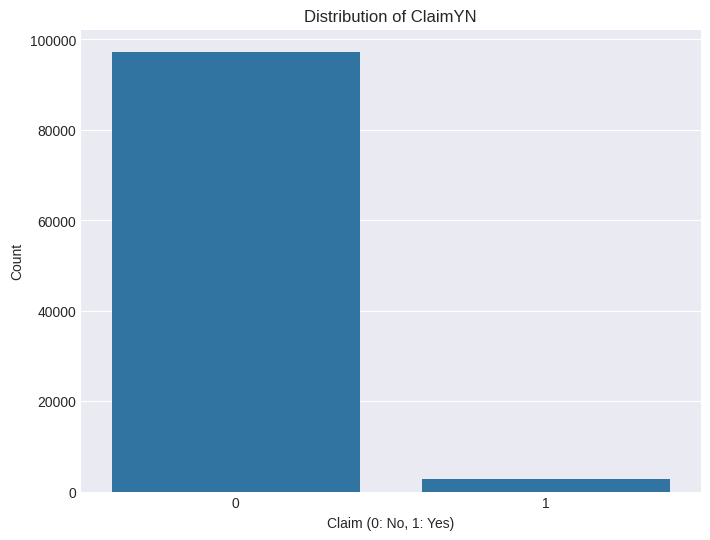

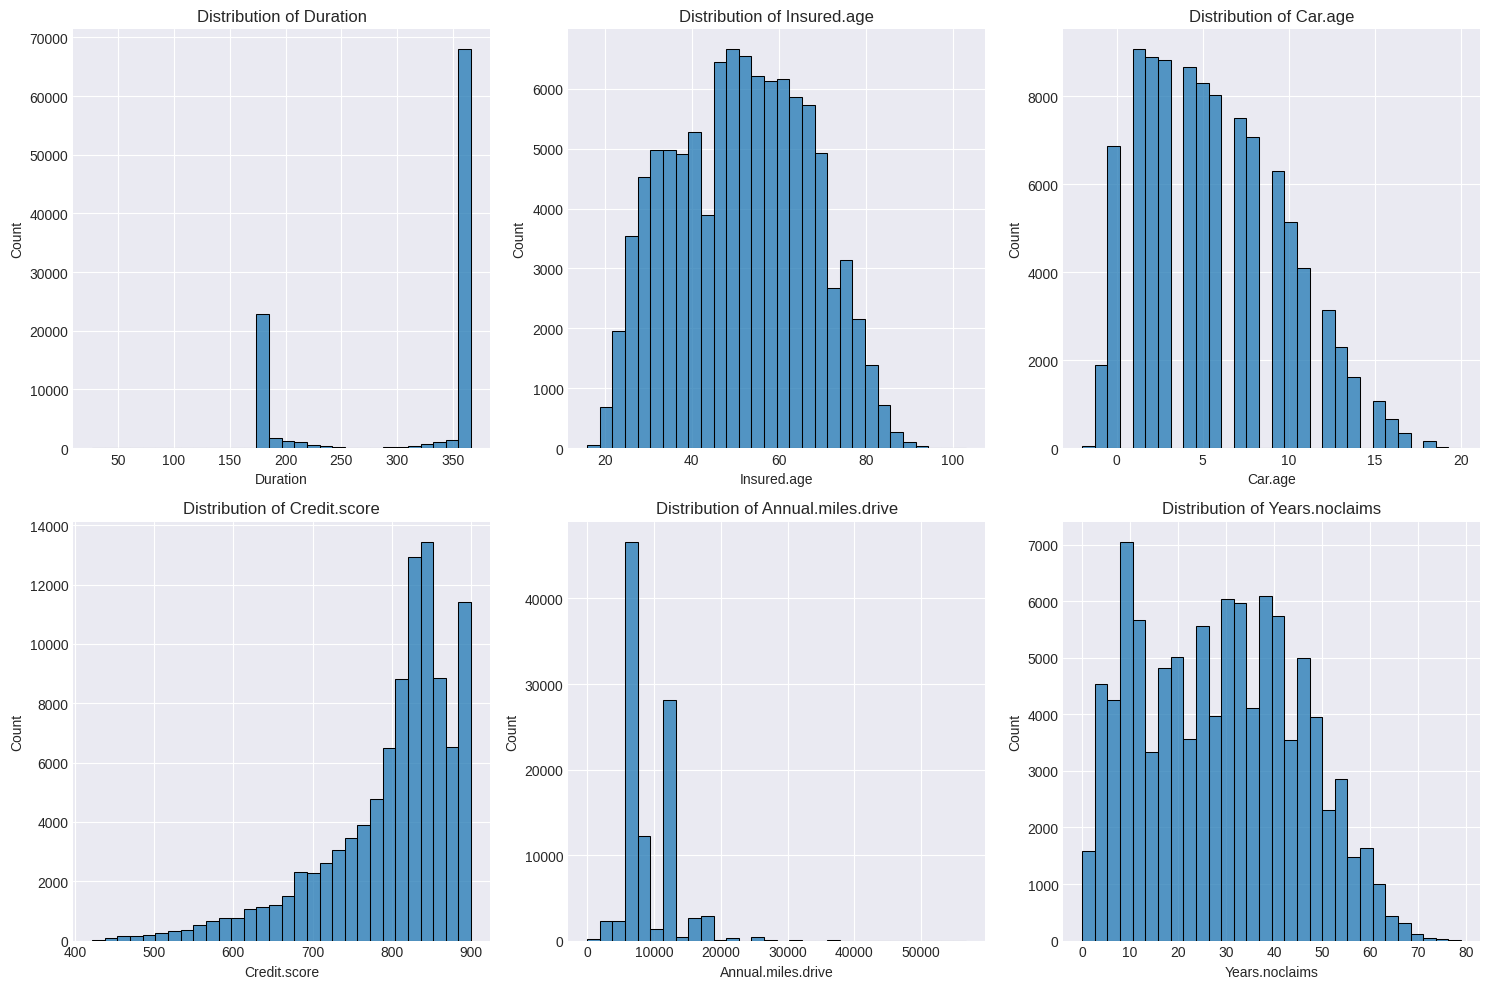

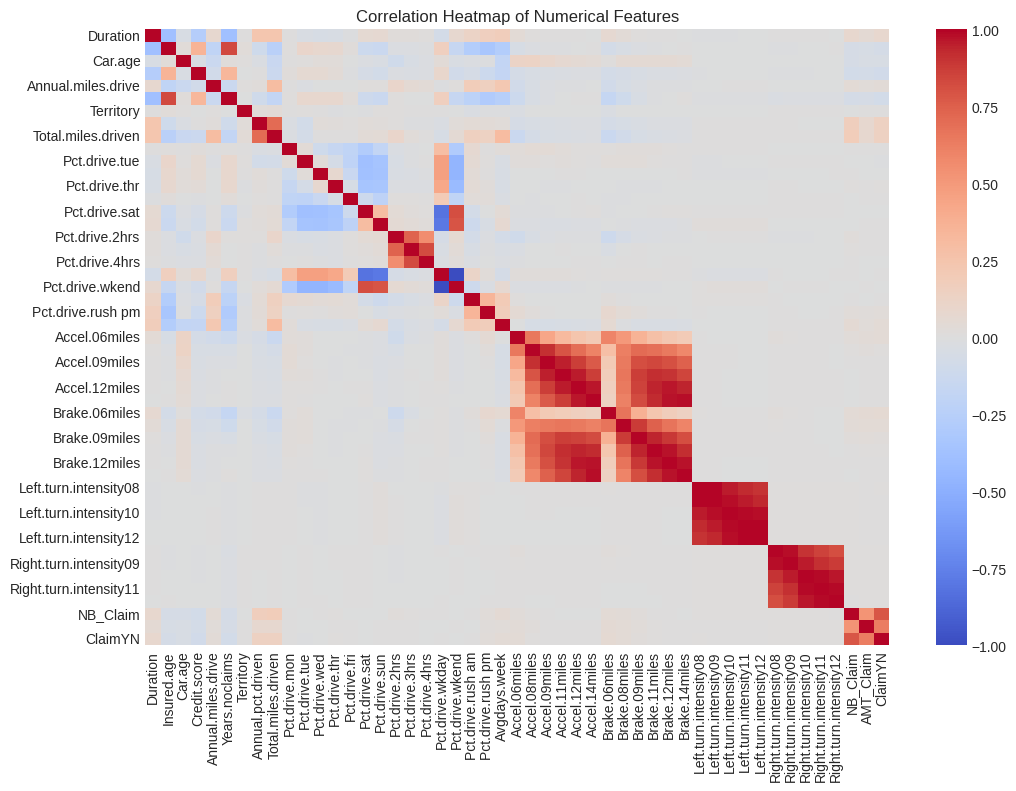

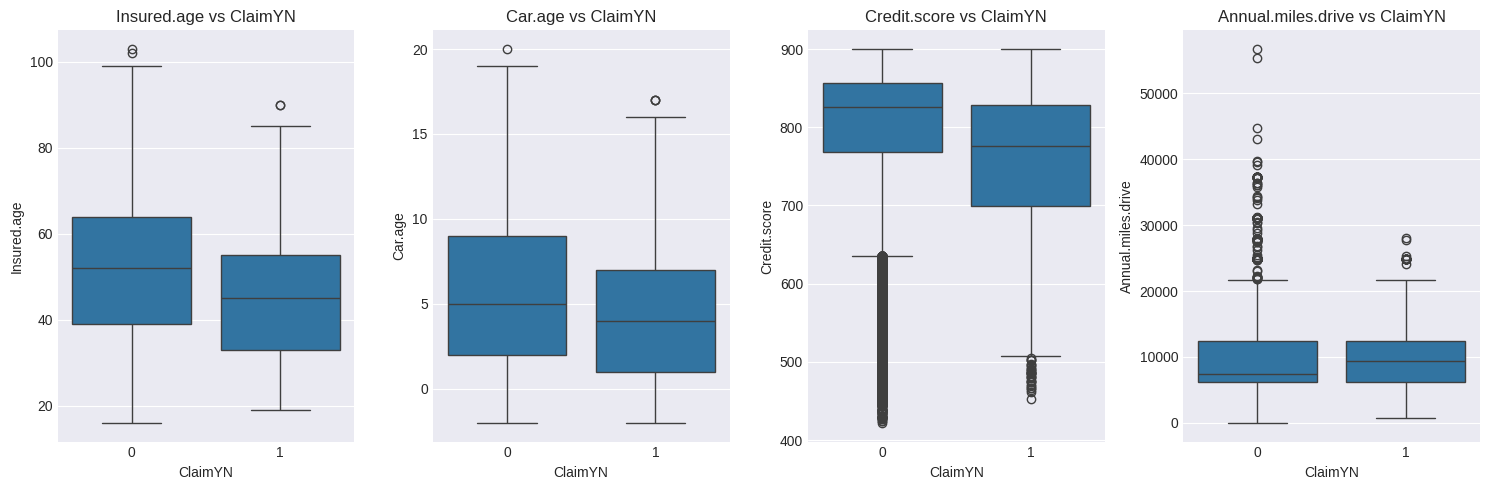

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import shap
import lime.lime_tabular
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

def load_and_eda(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Basic info
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    # EDA Visualizations
    # 1. Class Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='ClaimYN', data=df)
    plt.title('Distribution of ClaimYN')
    plt.xlabel('Claim (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()

    # 2. Numerical Features Distribution
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols[:6], 1):  # Show first 6 for brevity
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # 4. Box Plots for Key Features vs ClaimYN
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='ClaimYN', y=col, data=df)
        plt.title(f'{col} vs ClaimYN')
    plt.tight_layout()
    plt.show()

    return df

# Usage
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = load_and_eda(file_path)

# Step 2: Preprocessing



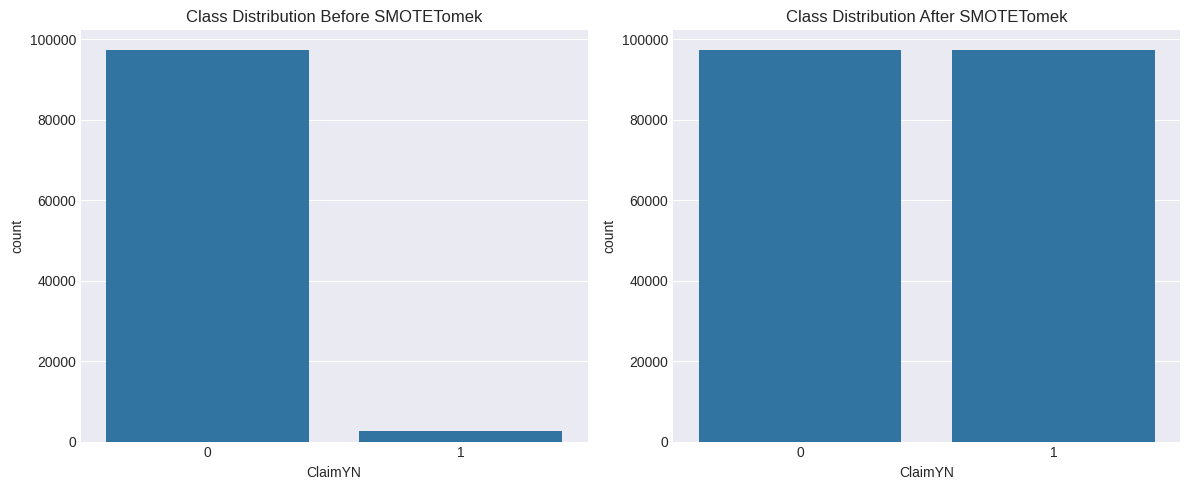

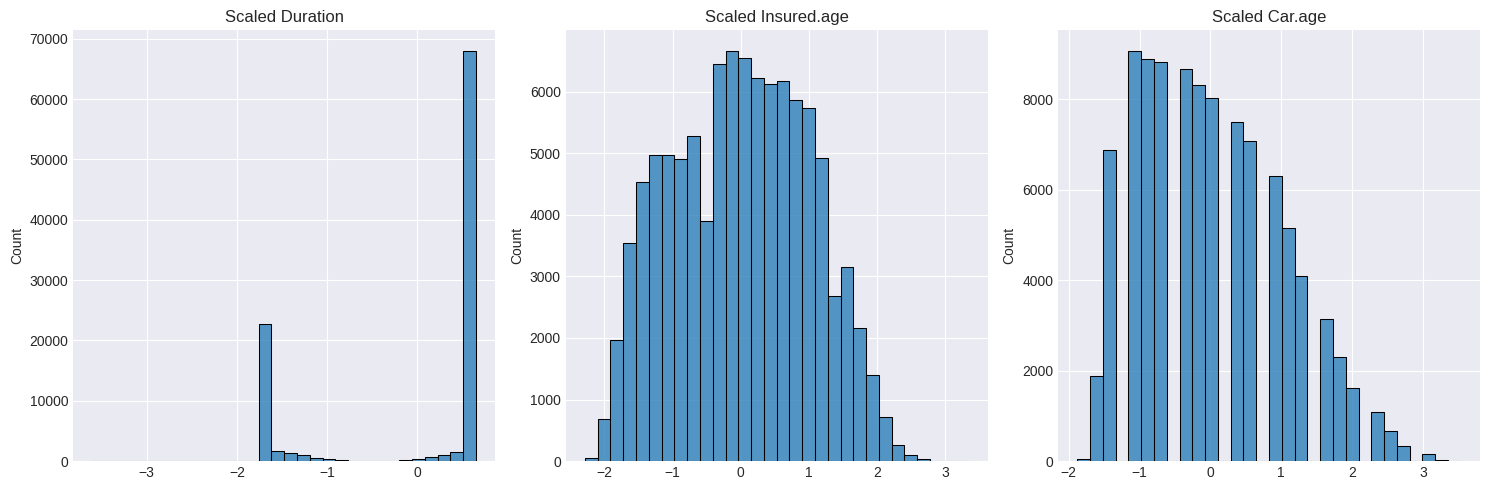

In [ ]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Encode categorical variables
    df = pd.get_dummies(df, drop_first=True)

    # Separate features and target
    X = df.drop('ClaimYN', axis=1)
    y = df['ClaimYN']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_scaled, y)

    # Visualizations
    # 1. Class Distribution Before and After SMOTETomek
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['ClaimYN'])
    plt.title('Class Distribution Before SMOTETomek')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Class Distribution After SMOTETomek')
    plt.tight_layout()
    plt.show()

    # 2. Scaled Feature Distribution
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(X.columns[:3], 1):  # Show first 3 for brevity
        plt.subplot(1, 3, i)
        sns.histplot(X_scaled[:, X.columns.get_loc(col)], bins=30)
        plt.title(f'Scaled {col}')
    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled, X.columns.tolist()

# Usage
X, y, feature_names = preprocess_data(df)

# Step 3: Feature Engineering



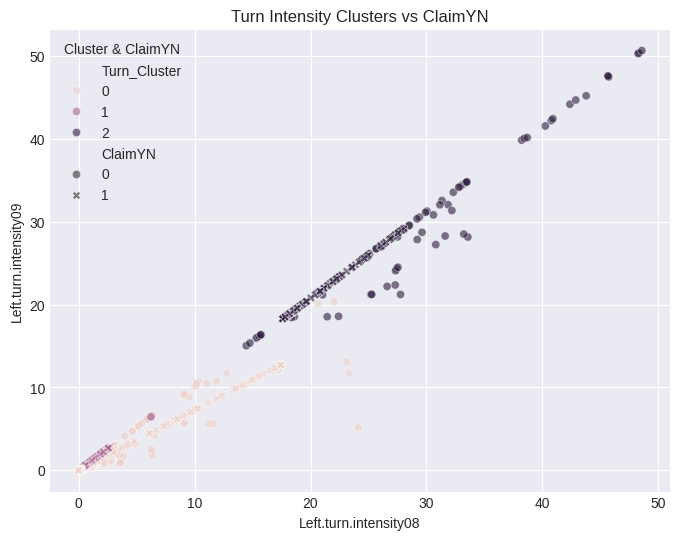

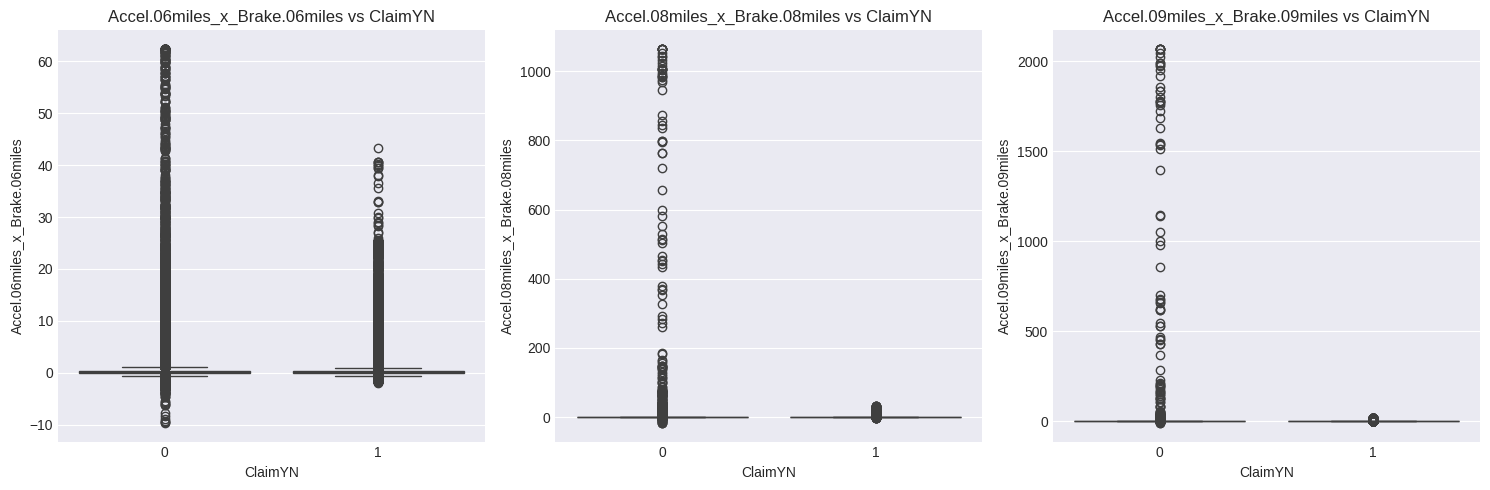

In [ ]:
def feature_engineering(X, feature_names, y):
    X_df = pd.DataFrame(X, columns=feature_names)

    # Interaction terms
    accel_cols = [col for col in feature_names if 'Accel' in col]
    brake_cols = [col for col in feature_names if 'Brake' in col]
    for accel, brake in zip(accel_cols, brake_cols):
        X_df[f'{accel}_x_{brake}'] = X_df[accel] * X_df[brake]

    # Cluster turn intensities
    turn_cols = [col for col in feature_names if 'turn.intensity' in col]
    if turn_cols:
        kmeans = KMeans(n_clusters=3, random_state=42)
        X_df['Turn_Cluster'] = kmeans.fit_predict(X_df[turn_cols])

        # Visualization: Cluster Scatter Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_df[turn_cols[0]], y=X_df[turn_cols[1]], hue=X_df['Turn_Cluster'], style=y, alpha=0.6)
        plt.title('Turn Intensity Clusters vs ClaimYN')
        plt.xlabel(turn_cols[0])
        plt.ylabel(turn_cols[1])
        plt.legend(title='Cluster & ClaimYN')
        plt.show()

    # Interaction Terms vs ClaimYN
    interaction_cols = [col for col in X_df.columns if '_x_' in col]
    if interaction_cols:
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(interaction_cols[:3], 1):  # Show first 3
            plt.subplot(1, 3, i)
            sns.boxplot(x=y, y=X_df[col])
            plt.title(f'{col} vs ClaimYN')
        plt.tight_layout()
        plt.show()

    return X_df.values, X_df.columns.tolist()

# Usage
X, feature_names = feature_engineering(X, feature_names, y)

# Step 4: Feature Selection



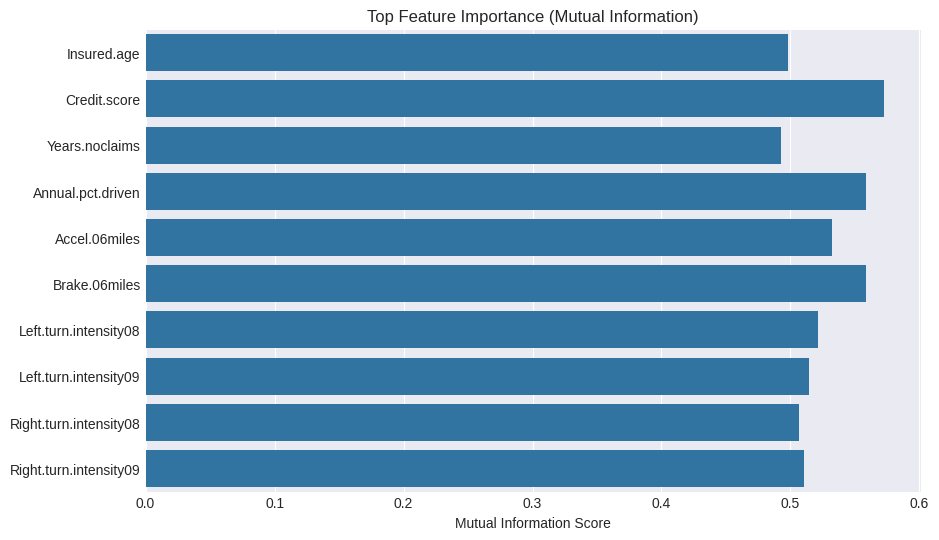

Top Features:
Credit.score: 0.5723
Brake.06miles: 0.5586
Annual.pct.driven: 0.5583
Accel.06miles: 0.5323
Left.turn.intensity08: 0.5211
Left.turn.intensity09: 0.5145
Right.turn.intensity09: 0.5105
Right.turn.intensity08: 0.5064
Insured.age: 0.4980
Years.noclaims: 0.4927


In [ ]:
def feature_selection(X_train, y_train, feature_names, top_k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    scores = selector.scores_

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores[selected_indices], y=selected_features)
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.show()

    print("Top Features:")
    for feature, score in sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features, selector.transform(X_train), selector.transform(X_test)

# Split data before feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selected_features, X_train_selected, X_test_selected = feature_selection(X_train, y_train, feature_names)

# Step 5: Variational Autoencoder (VAE)



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class Sampling(Layer):
    """Custom Keras layer for sampling from a normal distribution."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    """Custom VAE model to handle loss computation."""
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * data.shape[1]  # Scale by input dimension
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def create_vae(X_train, X_test, latent_dim=32):
    """
    Create and train a Variational Autoencoder.

    Parameters:
    - X_train: Training data (NumPy array)
    - X_test: Test data (NumPy array)
    - latent_dim: Dimension of the latent space

    Returns:
    - X_train_ae: Encoded training features
    - X_test_ae: Encoded test features
    """
    # Normalize inputs to [0, 1] for binary cross-entropy
    X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())

    # Input dimension
    input_dim = X_train.shape[1]

    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(64, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(decoder_h)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam')

    # Train
    vae.fit(X_train_norm, epochs=50, batch_size=32, verbose=0)

    # Get latent features
    X_train_ae = encoder.predict(X_train_norm, verbose=0)[2]  # Get z
    X_test_ae = encoder.predict(X_test_norm, verbose=0)[2]    # Get z

    # Visualization: Latent Space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train_ae[:, 0], y=X_train_ae[:, 1], hue=y_train, alpha=0.6)
    plt.title('VAE Latent Space vs ClaimYN')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(title='ClaimYN')
    plt.show()

    return X_train_ae, X_test_ae

# Step 6: Model Training with Bayesian Optimization



In [ ]:
def train_models(X_train, y_train):
    def objective(trial):
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 7)
        }
        gb = GradientBoostingClassifier(**gb_params, random_state=42)

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,50), (100,50), (100,100)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True)
        }
        nn = MLPClassifier(**nn_params, max_iter=1000, random_state=42)

        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50)
        }
        lgb = LGBMClassifier(**lgb_params, random_state=42)

        estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
        stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

        scores = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc')
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Visualization: Optimization History
    plt.figure(figsize=(8, 6))
    optuna.visualization.plot_optimization_history(study)
    plt.title('Hyperparameter Optimization History')
    plt.show()

    # Train final models
    best_params = study.best_params
    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=1000,
        random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42
    )

    estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
    stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    for name, model in estimators:
        model.fit(X_train, y_train)
    stack.fit(X_train, y_train)

    return {'gb': gb, 'nn': nn, 'lgb': lgb, 'stack': stack}



# Step 7: Model Evaluation



In [ ]:
def evaluate_models(models, X_test, y_test):
    results = {}
    plt.figure(figsize=(15, 10))

    # ROC Curves
    plt.subplot(2, 2, 1)
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
        y_pred = model.predict(X_test)

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()

    # Confusion Matrices
    for i, (name, model) in enumerate(models.items(), 2):
        plt.subplot(2, 2, i)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    # Metrics Comparison
    metrics_df = pd.DataFrame(results).T
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar')
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results



# Step 8: Interpretability



In [ ]:
def interpret_models(models, X_train, X_test, feature_names, sample_idx=0):
    explainer = shap.KernelExplainer(
        models['stack'].predict_proba, shap.sample(X_train, 100)
    )
    shap_values = explainer.shap_values(X_test[sample_idx:sample_idx+1])

    # SHAP Summary Plot
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance')
    plt.show()

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train, feature_names=feature_names, class_names=['No Claim', 'Claim'], mode='classification'
    )
    lime_exp = lime_explainer.explain_instance(X_test[sample_idx], models['stack'].predict_proba)

    # LIME Plot
    lime_exp.show_in_notebook(show_table=True, show_all=False)

    return shap_values, lime_exp


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.dri

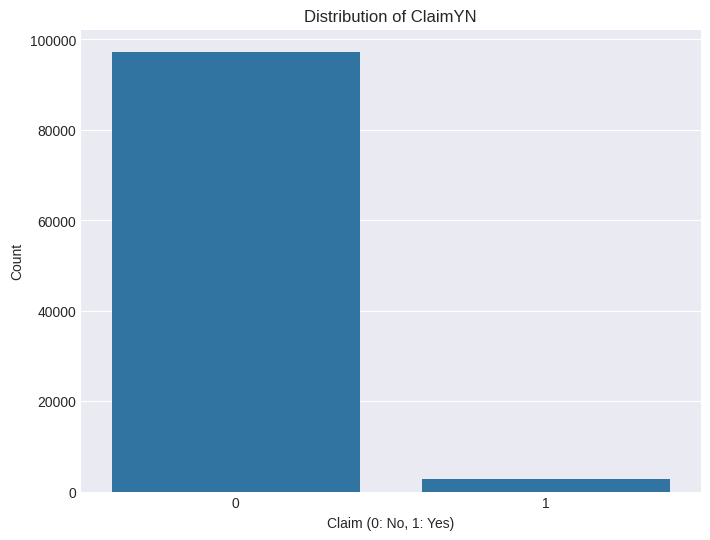

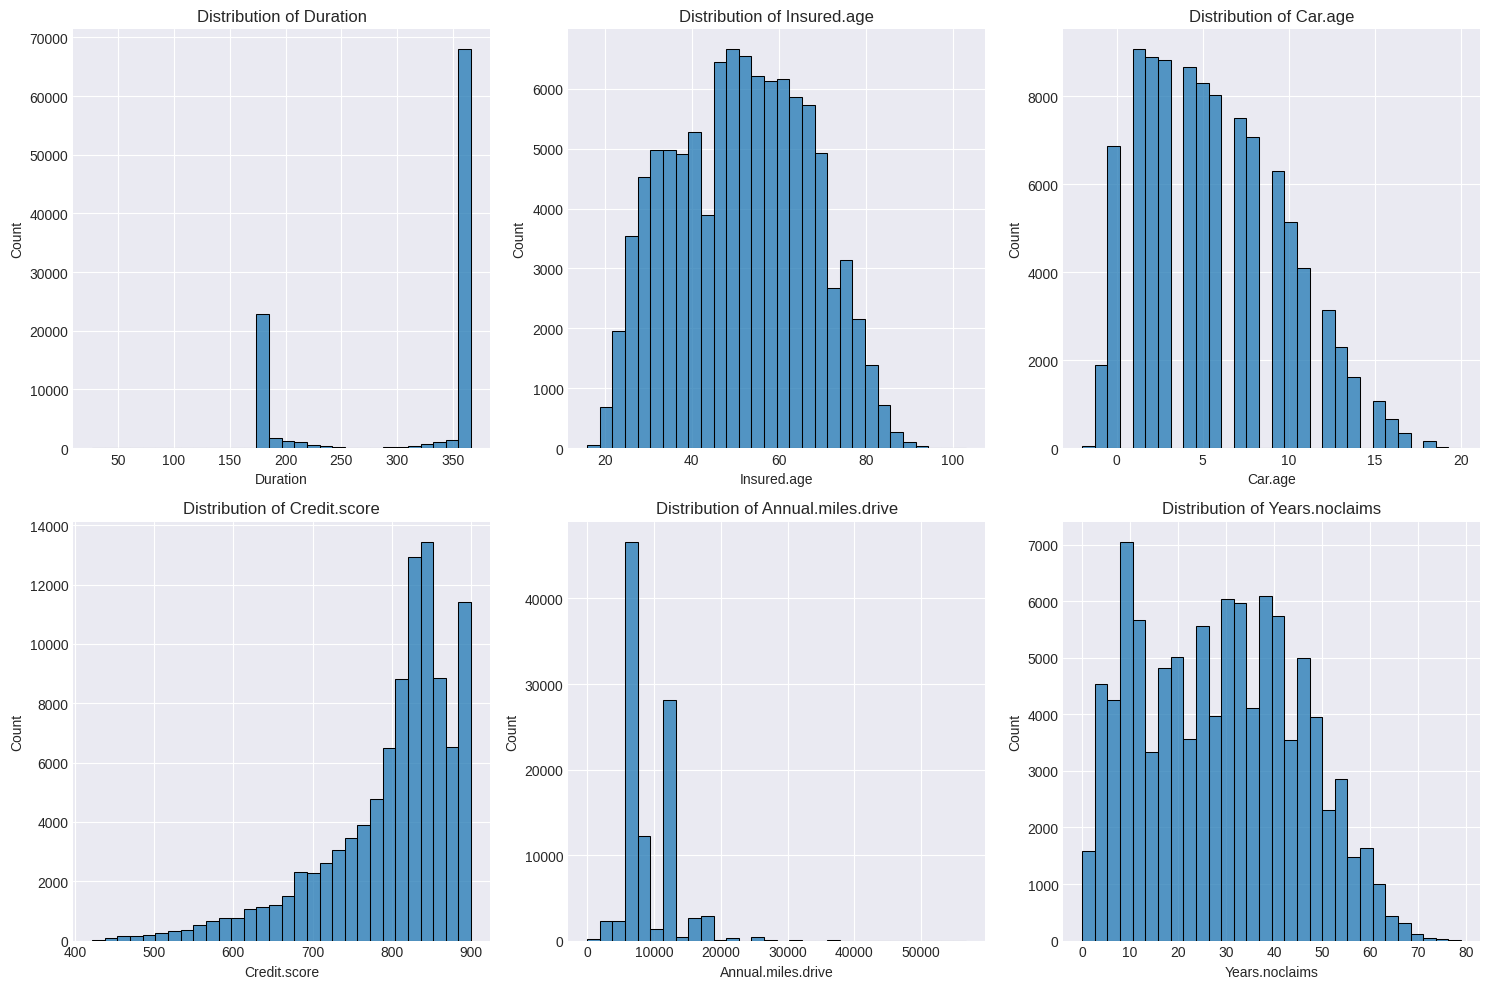

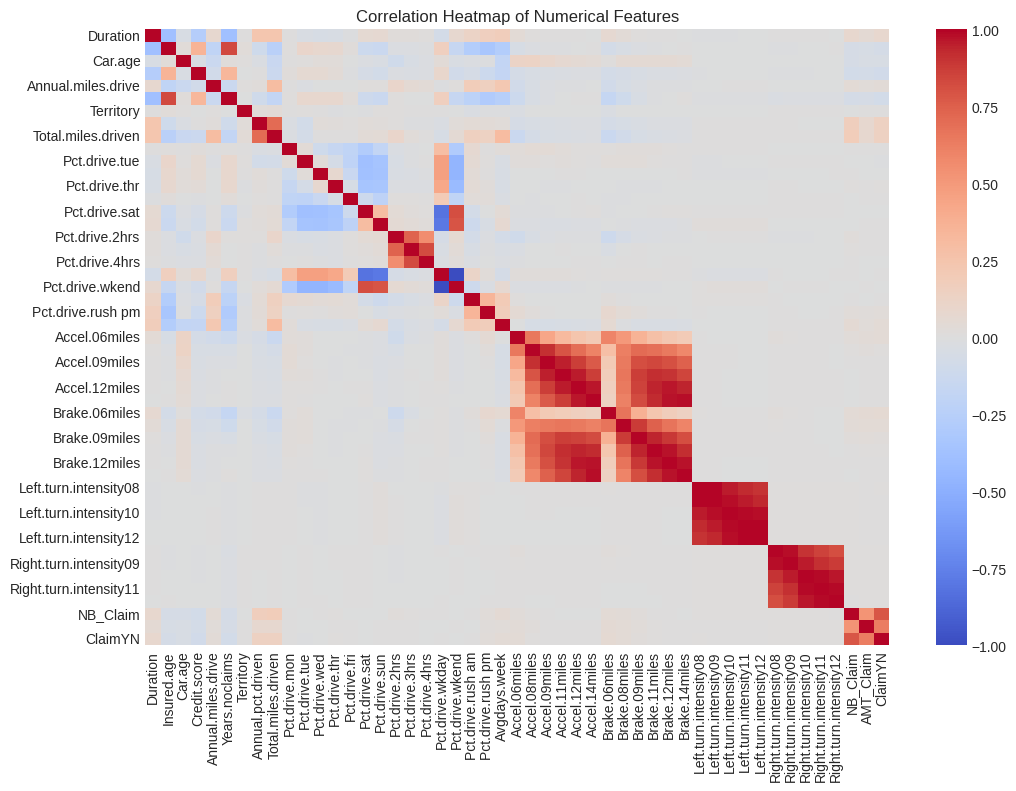

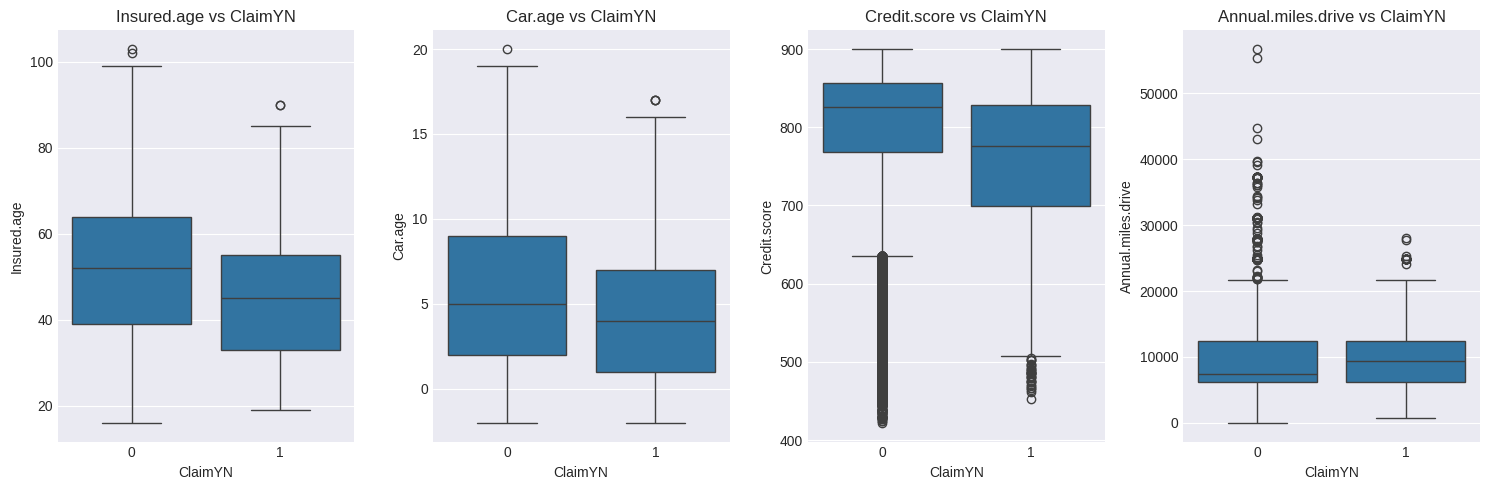

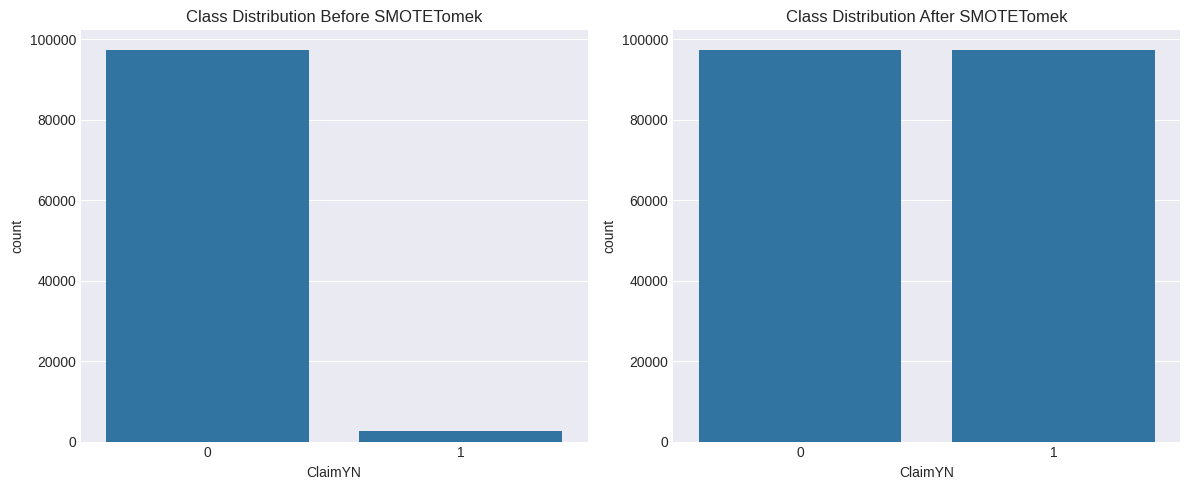

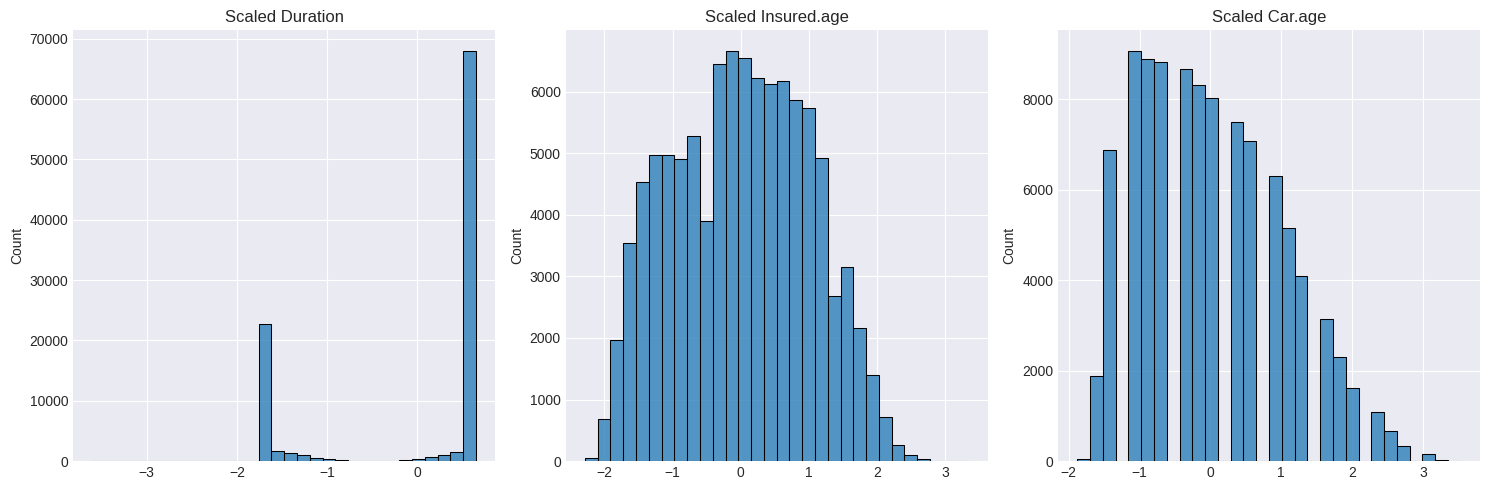

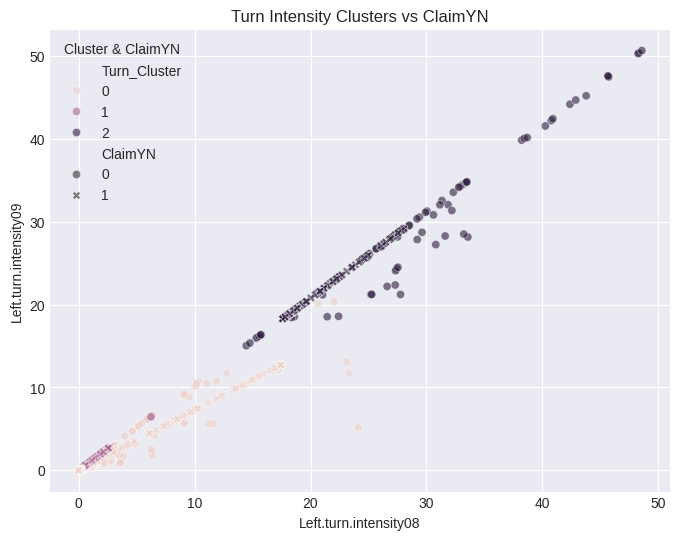

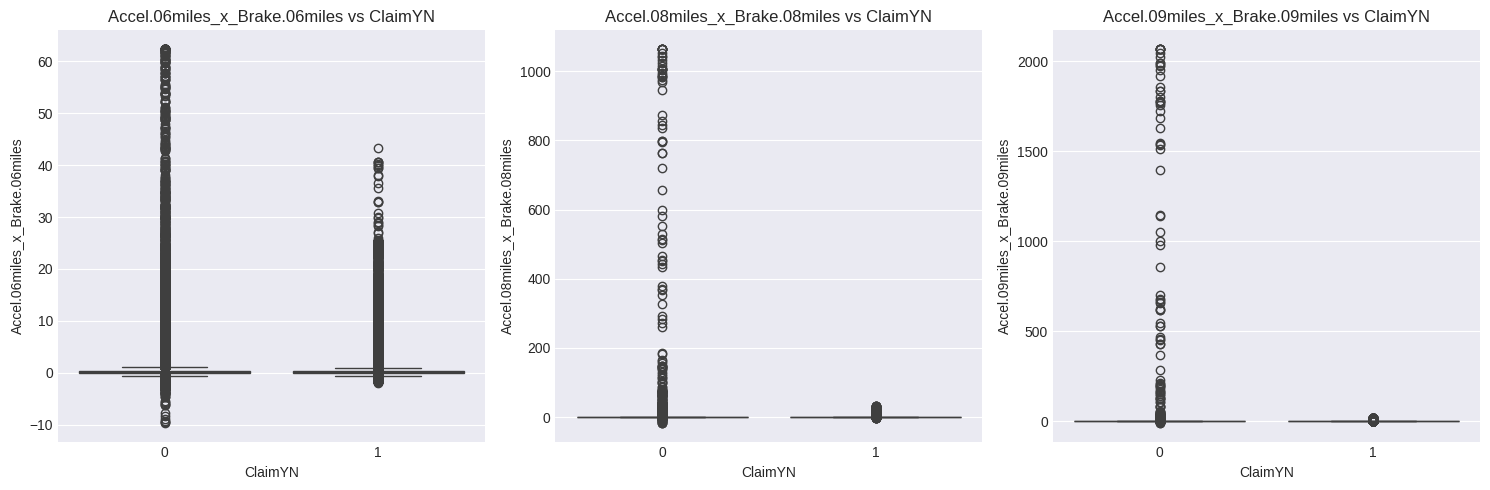

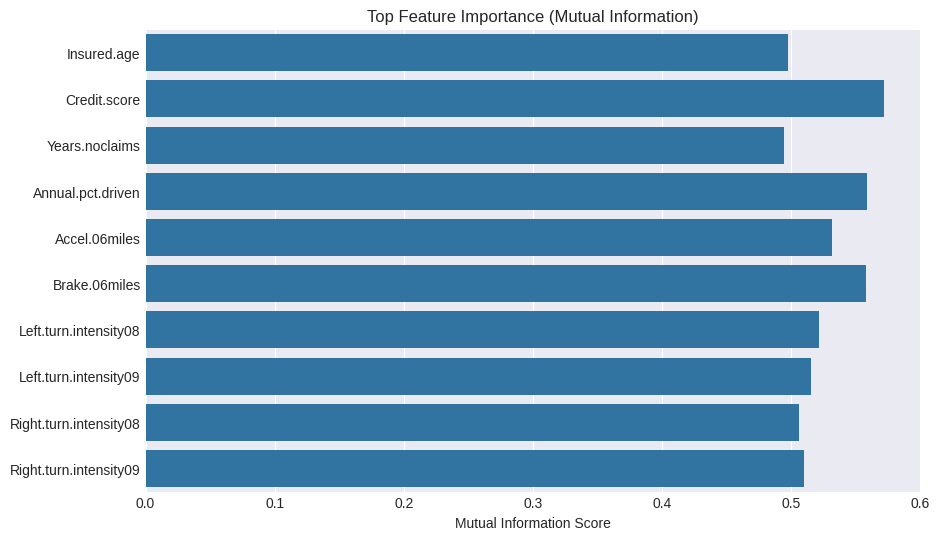

Top Features:
Credit.score: 0.5717
Annual.pct.driven: 0.5585
Brake.06miles: 0.5579
Accel.06miles: 0.5319
Left.turn.intensity08: 0.5212
Left.turn.intensity09: 0.5151
Right.turn.intensity09: 0.5098
Right.turn.intensity08: 0.5063
Insured.age: 0.4976
Years.noclaims: 0.4943


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Combine all steps
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'

# Step 1: EDA
df = load_and_eda(file_path)

# Step 2: Preprocessing
X, y, feature_names = preprocess_data(df)

# Step 3: Feature Engineering
X, feature_names = feature_engineering(X, feature_names, y)

# Step 4: Split Data and Feature Selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selected_features, X_train_selected, X_test_selected = feature_selection(X_train, y_train, feature_names)

# Step 5: Variational Autoencoder
X_train_ae, X_test_ae = create_vae(X_train_selected, X_test_selected)

# Step 6: Train Models
models = train_models(X_train_ae, y_train)

# Step 7: Evaluate Models
results = evaluate_models(models, X_test_ae, y_test)

# Step 8: Interpret Models
shap_values, lime_exp = interpret_models(models, X_train_ae, X_test_ae, selected_features)

# Jul 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.drive.tue        

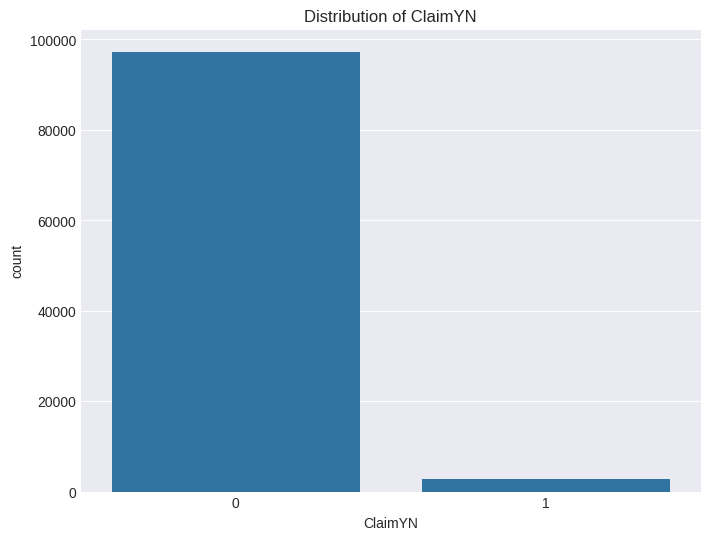

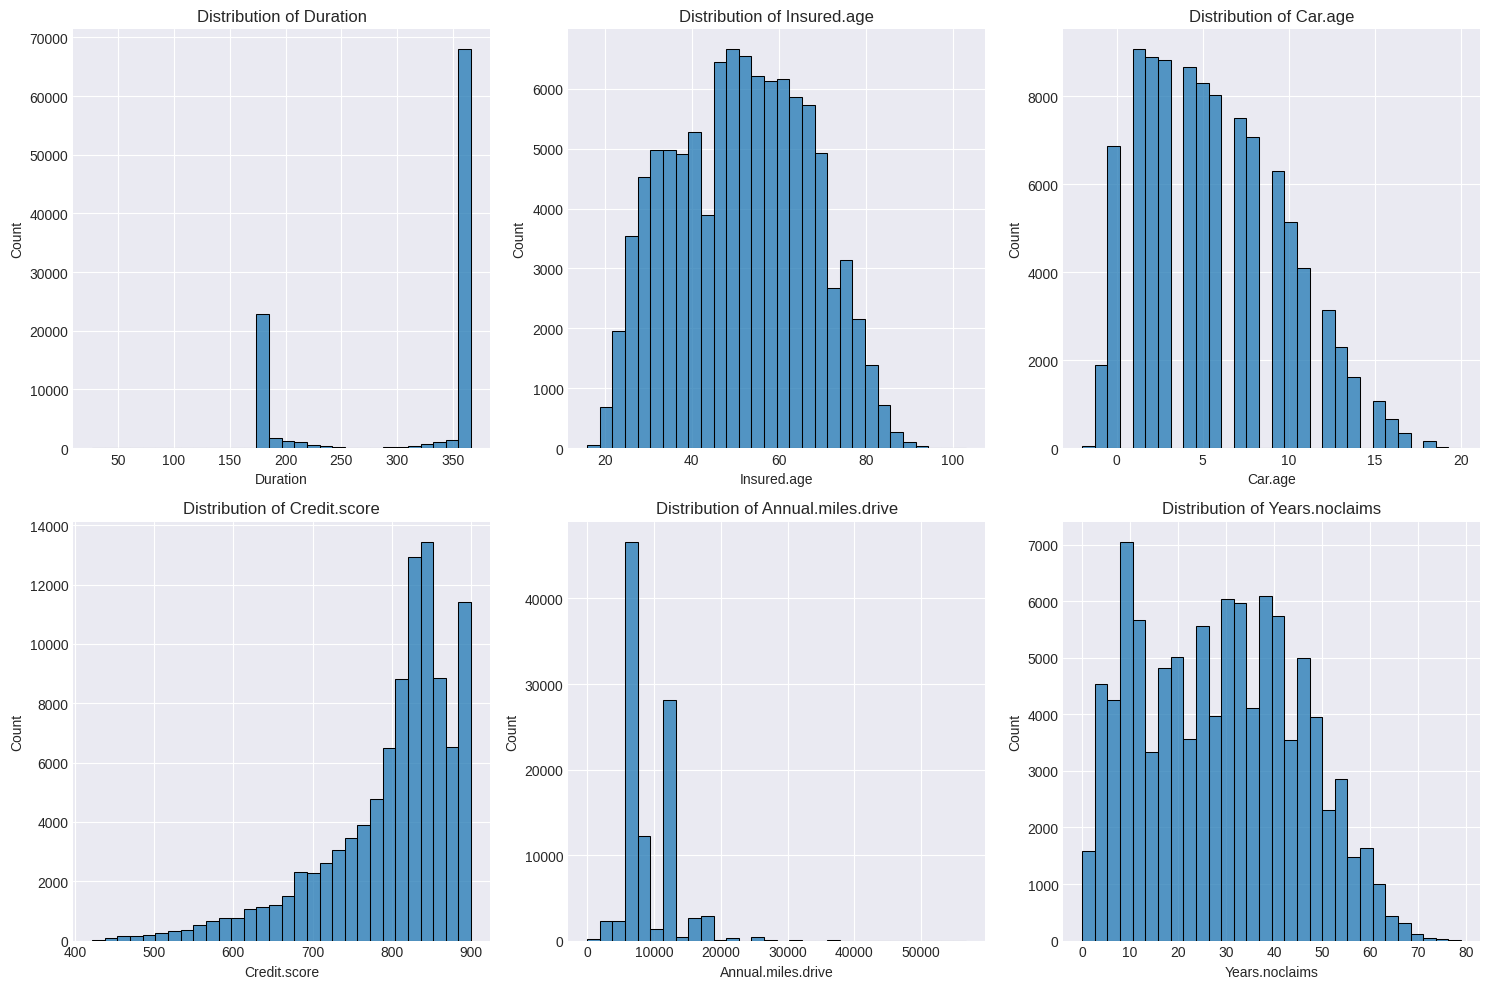

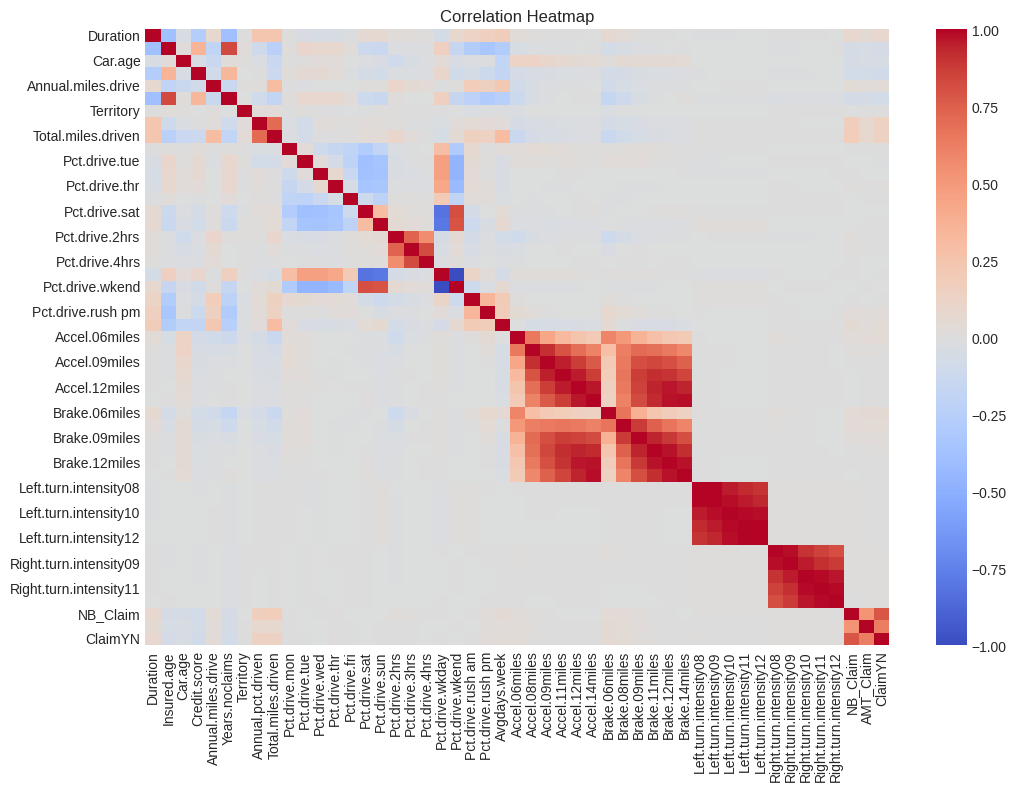

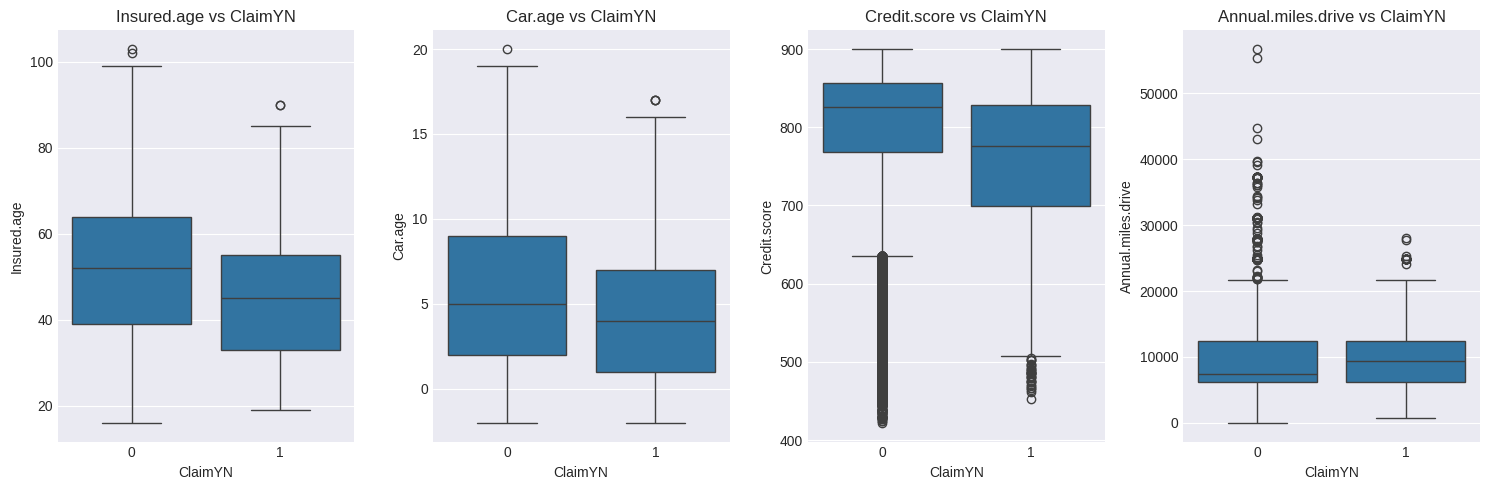

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Class distribution after SMOTETomek: ClaimYN
1    97136
0    97136
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1117: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  if np.may_share_memory(array, array_orig):


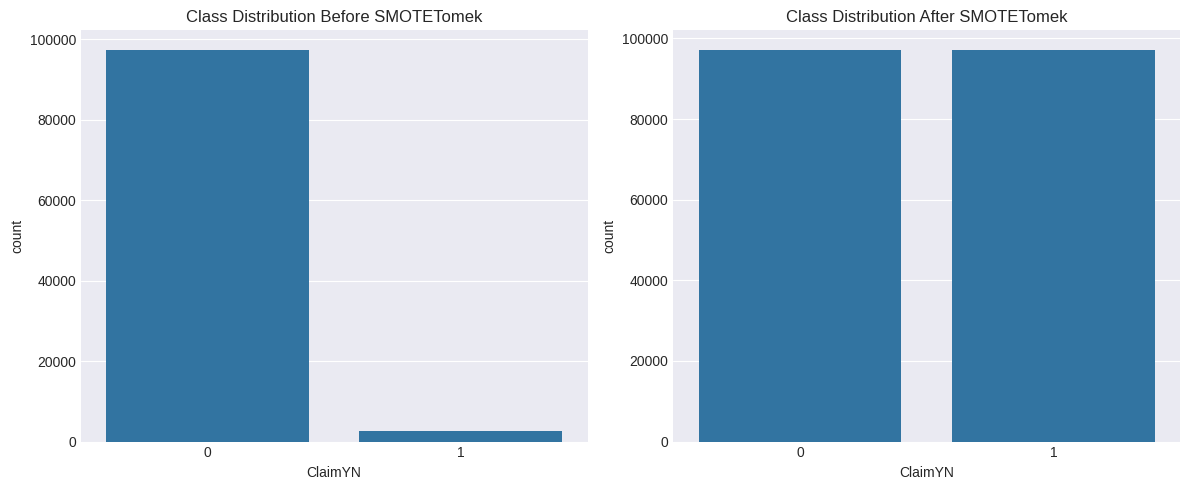

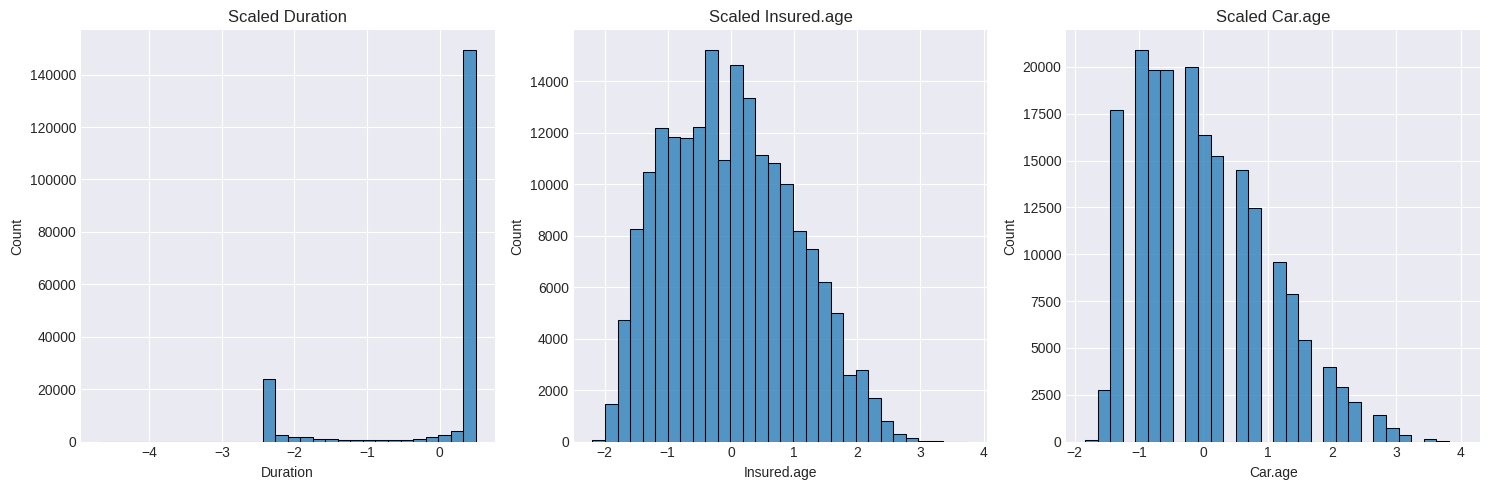

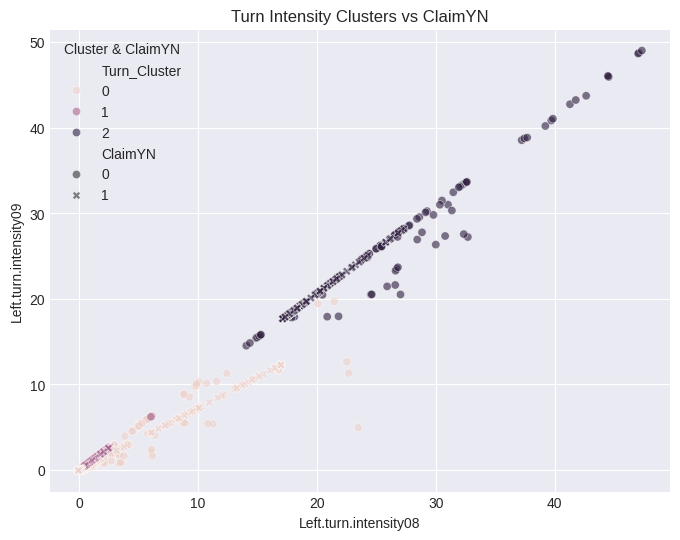

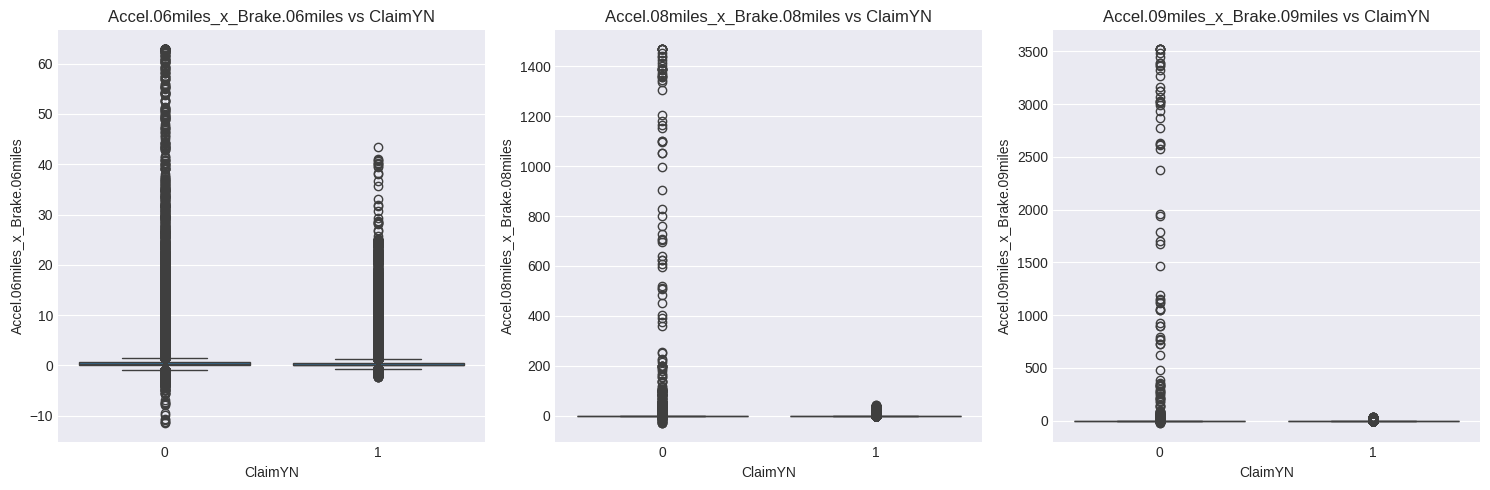

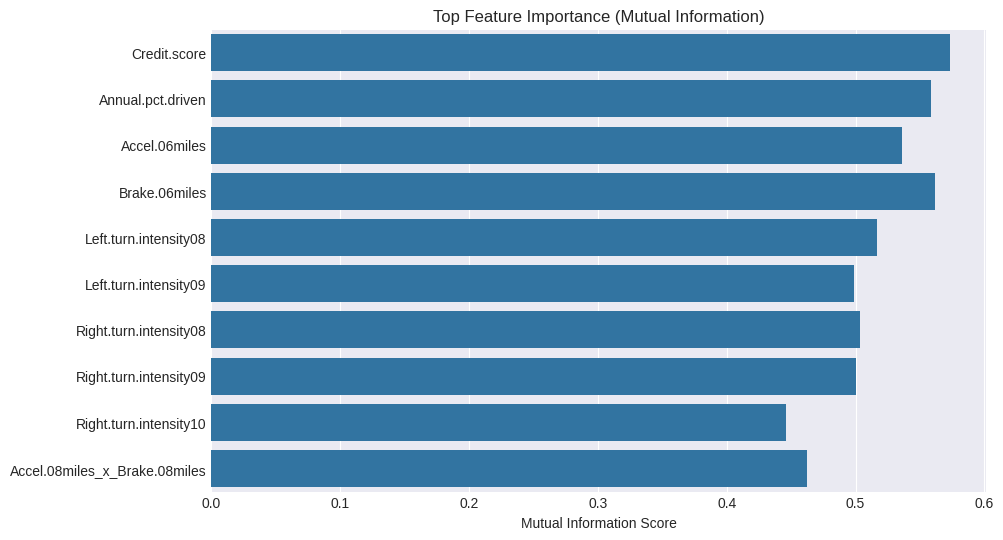

Top Features:
Credit.score: 0.5730
Brake.06miles: 0.5616
Annual.pct.driven: 0.5588
Accel.06miles: 0.5357
Left.turn.intensity08: 0.5169
Right.turn.intensity08: 0.5033
Right.turn.intensity09: 0.5003
Left.turn.intensity09: 0.4984
Accel.08miles_x_Brake.08miles: 0.4625
Right.turn.intensity10: 0.4460


NameError: name 'create_vae' is not defined

In [ ]:
# Imports and random seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import shap
import lime.lime_tabular
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.cluster import KMeans # Import KMeans

np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# Step 1: Load and EDA
def load_and_eda(file_path):
    df = pd.read_csv(file_path)
    print("Dataset Info:", df.info())
    print("\nMissing Values:", df.isnull().sum())
    print("\nSummary Statistics:", df.describe())

    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    plt.figure(figsize=(8, 6))
    sns.countplot(x='ClaimYN', data=df)
    plt.title('Distribution of ClaimYN')
    plt.show()

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols[:6], 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='ClaimYN', y=col, data=df)
        plt.title(f'{col} vs ClaimYN')
    plt.tight_layout()
    plt.show()

    return df

# Step 2: Preprocessing
def preprocess_data(df):
    df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)
    df = pd.get_dummies(df, drop_first=True, sparse=True)
    X = df.drop('ClaimYN', axis=1)
    y = df['ClaimYN']

    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X, y)
    print("Class distribution after SMOTETomek:", pd.Series(y_resampled).value_counts())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['ClaimYN'])
    plt.title('Class Distribution Before SMOTETomek')
    plt.subplot(1, 2, 2)
    sns.countplot(x=pd.Series(y_resampled, name='ClaimYN'))
    plt.title('Class Distribution After SMOTETomek')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(X.columns[:3], 1):
        plt.subplot(1, 3, i)
        sns.histplot(X_scaled_df[col], bins=30)
        plt.title(f'Scaled {col}')
    plt.tight_layout()
    plt.show()

    return X_scaled, y_resampled, X.columns.tolist()

# Step 3: Feature Engineering
def feature_engineering(X, feature_names, y):
    X_df = pd.DataFrame(X, columns=feature_names)

    accel_cols = [col for col in feature_names if 'Accel' in col]
    brake_cols = [col for col in feature_names if 'Brake' in col]
    if len(accel_cols) != len(brake_cols):
        raise ValueError("Mismatch between acceleration and brake columns")
    for accel, brake in zip(accel_cols, brake_cols):
        X_df[f'{accel}_x_{brake}'] = X_df[accel] * X_df[brake]

    turn_cols = [col for col in feature_names if 'turn.intensity' in col]
    if turn_cols:
        turn_scaled = StandardScaler().fit_transform(X_df[turn_cols])
        kmeans = KMeans(n_clusters=3, random_state=42)
        X_df['Turn_Cluster'] = kmeans.fit_predict(turn_scaled)

        if len(turn_cols) >= 2:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=X_df[turn_cols[0]], y=X_df[turn_cols[1]], hue=X_df['Turn_Cluster'], style=y, alpha=0.6)
            plt.title('Turn Intensity Clusters vs ClaimYN')
            plt.xlabel(turn_cols[0])
            plt.ylabel(turn_cols[1])
            plt.legend(title='Cluster & ClaimYN')
            plt.show()

    interaction_cols = [col for col in X_df.columns if '_x_' in col]
    if interaction_cols:
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(interaction_cols[:3], 1):
            plt.subplot(1, 3, i)
            sns.boxplot(x=y, y=X_df[col])
            plt.title(f'{col} vs ClaimYN')
        plt.tight_layout()
        plt.show()

    return X_df.values, X_df.columns.tolist()

# Step 4: Feature Selection
def feature_selection(X_train, y_train, X_test, feature_names, top_k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    scores = selector.scores_

    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores[selected_indices], y=selected_features)
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.show()

    print("Top Features:")
    for feature, score in sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features, selector.transform(X_train), selector.transform(X_test)

# Step 5: VAE (already provided above)

# Step 6: Model Training
def train_models(X_train, y_train):
    def objective(trial, X_train, y_train):
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 7)
        }
        gb = GradientBoostingClassifier(**gb_params, random_state=42)

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,50), (100,50), (100,100)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True),
            'early_stopping': True,
            'validation_fraction': 0.1
        }
        nn = MLPClassifier(**nn_params, max_iter=1000, random_state=42)

        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50)
        }
        lgb = LGBMClassifier(**lgb_params, random_state=42)

        estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
        stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

        scores = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc')
        return scores.mean()

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    plt.figure(figsize=(8, 6))
    optuna.visualization.plot_optimization_history(study)
    plt.title('Hyperparameter Optimization History')
    plt.show()

    best_params = study.best_params
    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42
    )

    estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
    stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    for name, model in estimators:
        model.fit(X_train, y_train)
    stack.fit(X_train, y_train)

    return {'gb': gb, 'nn': nn, 'lgb': lgb, 'stack': stack}

# Step 7: Model Evaluation
def evaluate_models(models, X_test, y_test):
    results = {}
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
        y_pred = model.predict(X_test)

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 5))
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(1, len(models), i)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame(results).T
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', colormap='viridis')
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()

    return results

# Step 8: Interpretability
def interpret_models(models, X_train, X_test, feature_names, sample_idx=0):
    if isinstance(models['stack'].final_estimator, GradientBoostingClassifier):
        explainer = shap.TreeExplainer(models['stack'].final_estimator)
    else:
        explainer = shap.KernelExplainer(models['stack'].predict_proba, shap.sample(X_train, 50))
    shap_values = explainer.shap_values(X_test[sample_idx:sample_idx+1])

    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance')
    plt.show()

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train, feature_names=feature_names, class_names=['No Claim', 'Claim'], mode='classification'
    )
    lime_exp = lime_explainer.explain_instance(X_test[sample_idx], models['stack'].predict_proba)
    lime_exp.save_to_file('lime_explanation.html')

    return shap_values, lime_exp

# Combine all steps
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = load_and_eda(file_path)
X, y, feature_names = preprocess_data(df)
X, feature_names = feature_engineering(X, feature_names, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selected_features, X_train_selected, X_test_selected = feature_selection(X_train, y_train, X_test, feature_names)
X_train_ae, X_test_ae = create_vae(X_train_selected, X_test_selected)
models = train_models(X_train_ae, y_train)
results = evaluate_models(models, X_test_ae, y_test)
shap_values, lime_exp = interpret_models(models, X_train_ae, X_test_ae, selected_features)

INSURANCE CLAIMS PREDICTION PIPELINE

1. Loading data and performing EDA...
Dataset Info:
Shape: (100000, 52)
Missing Values: 0

Target Distribution:
ClaimYN
0    97302
1     2698
Name: count, dtype: int64
Positive class ratio: 0.027


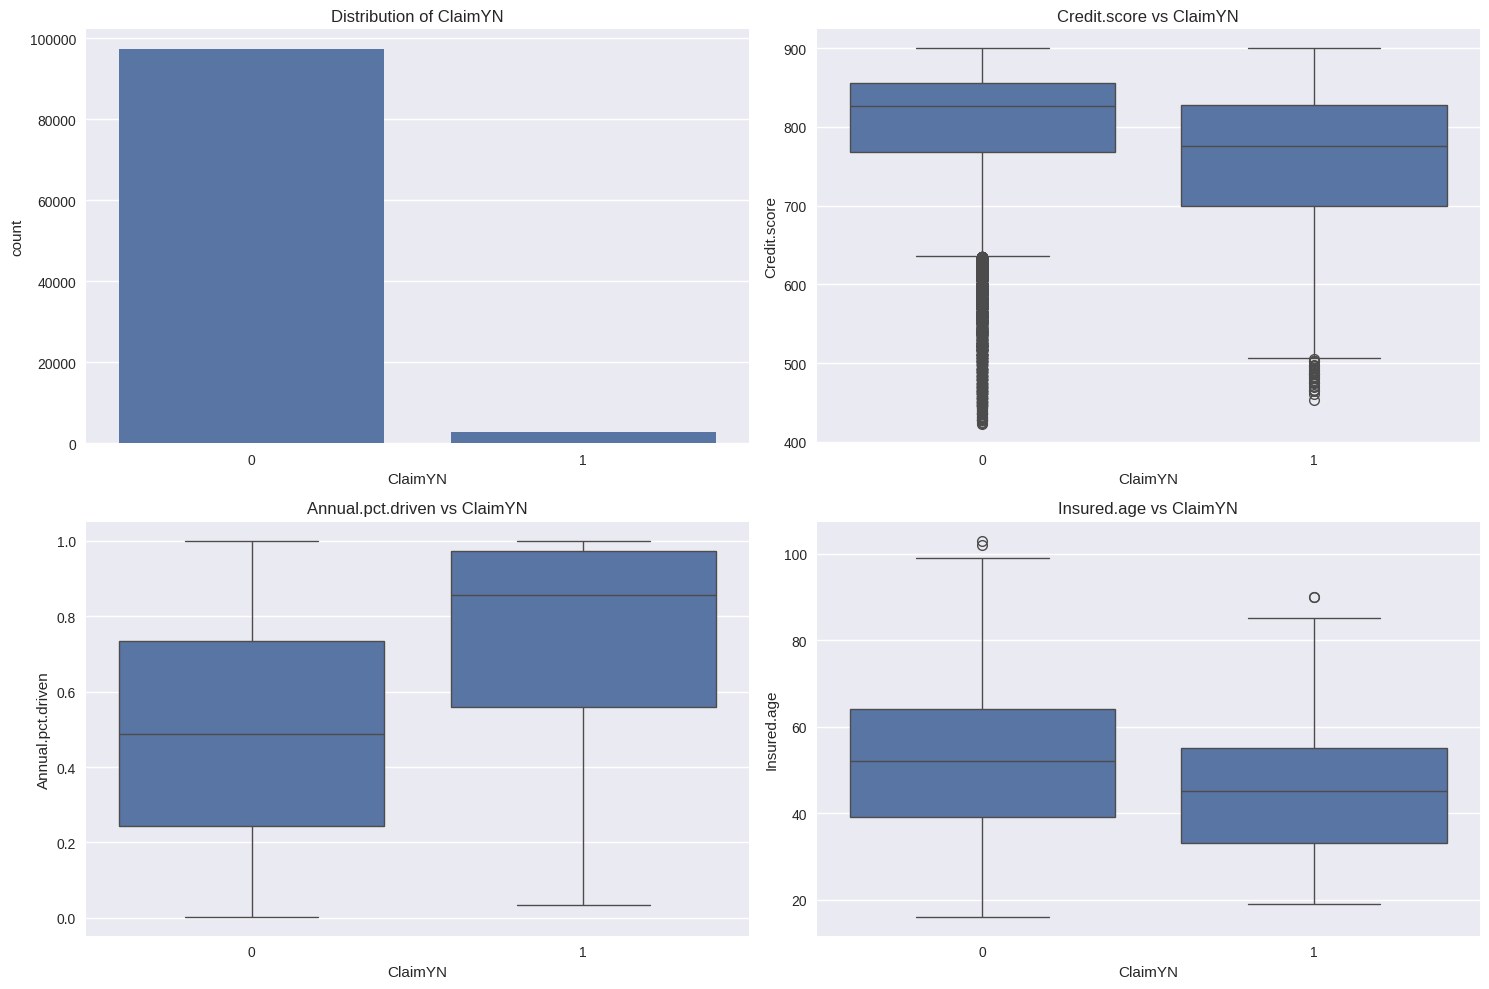


2. Preprocessing data...
Features shape after encoding: (100000, 52)

3. Splitting data...
Train set: (80000, 52), Test set: (20000, 52)

4. Feature engineering and selection...
Performing feature selection...
Selected 20 features


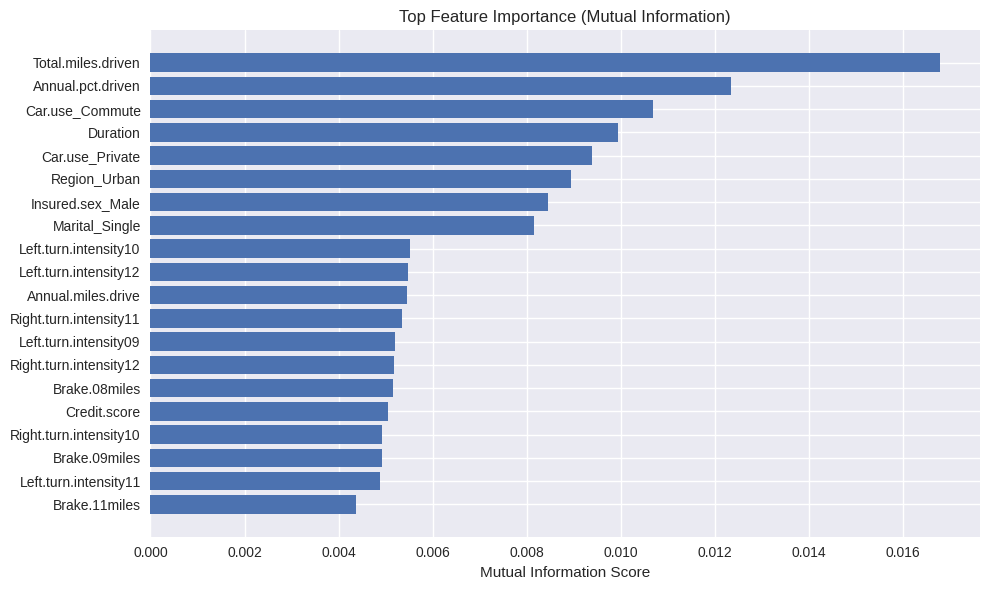

Applying PCA to reduce from 20 to 15 components...


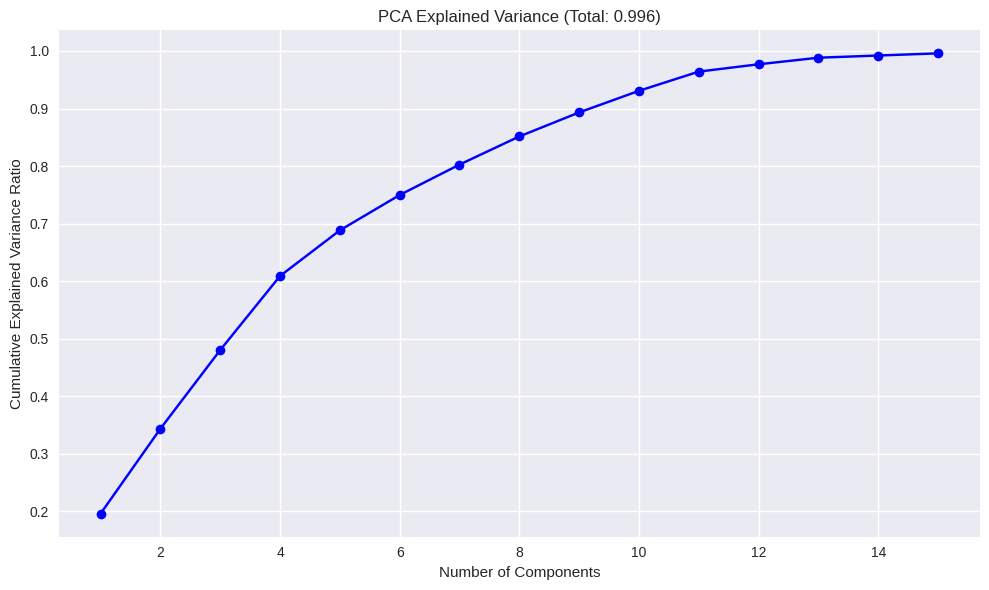

PCA explained variance ratio: 0.996

5. Handling class imbalance...
Handling class imbalance...
Original distribution: [77842  2158]
After SMOTETomek: [77772 77772]


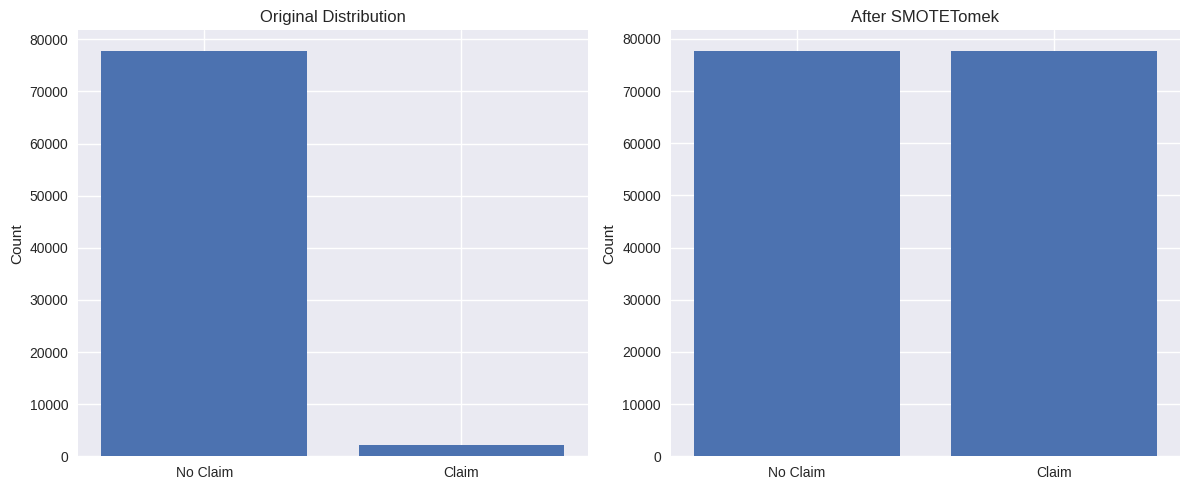

[I 2025-07-01 17:49:38,064] A new study created in memory with name: no-name-9f03f60e-f9d9-4905-887f-96c85a752bd2



6. Training and optimizing models...
Starting hyperparameter optimization...


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-07-01 18:14:54,807] Trial 0 failed with parameters: {'gb_n_estimators': 91, 'gb_learning_rate': 0.19646049048074815, 'gb_max_depth': 6, 'gb_subsample': 0.9194433780437952, 'nn_hidden_layers': (100, 50), 'nn_alpha': 1.332594999478241e-05, 'nn_lr': 0.00018613300530934826, 'lgb_n_estimators': 125, 'lgb_learning_rate': 0.09310100889619254, 'lgb_num_leaves': 31, 'lgb_min_child_samples': 26} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1682, in _get_outputs
    yield from self._retrieve()
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1800, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')

def load_and_eda(file_path):
    """Load dataset and perform exploratory data analysis"""
    # Load dataset
    df = pd.read_csv(file_path)

    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Missing Values: {df.isnull().sum().sum()}")

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    print(f"\nTarget Distribution:")
    print(df['ClaimYN'].value_counts())
    print(f"Positive class ratio: {df['ClaimYN'].mean():.3f}")

    # EDA Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Class Distribution
    sns.countplot(x='ClaimYN', data=df, ax=axes[0,0])
    axes[0,0].set_title('Distribution of ClaimYN')

    # 2. Key features vs target
    key_features = ['Credit.score', 'Annual.pct.driven', 'Insured.age']
    for i, feature in enumerate(key_features):
        if i < 3:
            row, col = (0, 1) if i == 0 else (1, i-1)
            sns.boxplot(x='ClaimYN', y=feature, data=df, ax=axes[row, col])
            axes[row, col].set_title(f'{feature} vs ClaimYN')

    plt.tight_layout()
    plt.show()

    return df

def preprocess_data(df):
    """Preprocess data with proper handling of categorical variables"""
    # Drop unnecessary columns
    df_processed = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Encode categorical variables
    df_encoded = pd.get_dummies(df_processed, drop_first=True)

    # Separate features and target
    X = df_encoded.drop('ClaimYN', axis=1)
    y = df_encoded['ClaimYN']

    print(f"Features shape after encoding: {X.shape}")

    return X, y

def feature_engineering_and_selection(X_train, X_test, y_train, n_components_pca=20, top_k_features=15):
    """
    Apply feature engineering, selection, and dimensionality reduction
    """
    # Step 1: Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Feature Selection using Mutual Information
    print("Performing feature selection...")
    selector = SelectKBest(score_func=mutual_info_classif, k=min(top_k_features, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = [X_train.columns[i] for i in selected_indices]

    print(f"Selected {len(selected_features)} features")

    # Visualize feature importance
    scores = selector.scores_[selected_indices]
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'score': scores
    }).sort_values('score', ascending=True)

    plt.barh(range(len(feature_importance_df)), feature_importance_df['score'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.show()

    # Step 3: PCA for further dimensionality reduction
    print(f"Applying PCA to reduce from {X_train_selected.shape[1]} to {n_components_pca} components...")
    pca = PCA(n_components=n_components_pca, random_state=42)
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)

    # Visualize PCA explained variance
    plt.figure(figsize=(10, 6))
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'PCA Explained Variance (Total: {cumsum_var[-1]:.3f})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"PCA explained variance ratio: {cumsum_var[-1]:.3f}")

    return X_train_pca, X_test_pca, scaler, selector, pca, selected_features

def handle_class_imbalance(X_train, y_train):
    """Handle class imbalance using SMOTETomek"""
    print("Handling class imbalance...")
    print(f"Original distribution: {np.bincount(y_train)}")

    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

    print(f"After SMOTETomek: {np.bincount(y_resampled)}")

    # Visualize class distribution before and after
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(['No Claim', 'Claim'], np.bincount(y_train))
    axes[0].set_title('Original Distribution')
    axes[0].set_ylabel('Count')

    axes[1].bar(['No Claim', 'Claim'], np.bincount(y_resampled))
    axes[1].set_title('After SMOTETomek')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled

def optimize_and_train_models(X_train, y_train, n_trials=30):
    """
    Optimize hyperparameters and train models using Bayesian optimization
    """
    print("Starting hyperparameter optimization...")

    def objective(trial):
        # Gradient Boosting parameters
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 150),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.05, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 6),
            'subsample': trial.suggest_float('gb_subsample', 0.8, 1.0)
        }

        # Neural Network parameters
        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers',
                                                           [(50,), (100,), (50,25), (100,50)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True),
            'learning_rate_init': trial.suggest_float('nn_lr', 1e-4, 1e-2, log=True)
        }

        # LightGBM parameters
        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 150),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.05, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 15, 40),
            'min_child_samples': trial.suggest_int('lgb_min_child_samples', 10, 50)
        }

        # Create models
        gb = GradientBoostingClassifier(**gb_params, random_state=42)
        nn = MLPClassifier(**nn_params, max_iter=500, random_state=42, early_stopping=True)
        lgb = LGBMClassifier(**lgb_params, random_state=42, verbose=-1)

        # Create stacking classifier
        estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
        stack = StackingClassifier(
            estimators=estimators,
            final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42),
            cv=3
        )

        # Cross-validation score
        scores = cross_val_score(stack, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
        return scores.mean()

    # Run optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"Best ROC-AUC: {study.best_value:.4f}")

    # Train final models with best parameters
    best_params = study.best_params

    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        subsample=best_params['gb_subsample'],
        random_state=42
    )

    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        learning_rate_init=best_params['nn_lr'],
        max_iter=500,
        random_state=42,
        early_stopping=True
    )

    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        min_child_samples=best_params['lgb_min_child_samples'],
        random_state=42,
        verbose=-1
    )

    # Create and train final stacking model
    estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42),
        cv=3
    )

    # Fit all models
    models = {'GradientBoosting': gb, 'NeuralNetwork': nn, 'LightGBM': lgb, 'StackingClassifier': stack}

    print("Training final models...")
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

    return models, study

def evaluate_models(models, X_test, y_test):
    """Comprehensive model evaluation"""
    results = {}

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # ROC Curves
    ax_roc = axes[0, 0]
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        ax_roc.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

        y_pred = model.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curves')
    ax_roc.legend()
    ax_roc.grid(True)

    # Confusion Matrix for best model (StackingClassifier)
    best_model = models['StackingClassifier']
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_best)

    ax_cm = axes[0, 1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title('Confusion Matrix (Stacking Classifier)')
    ax_cm.set_ylabel('True Label')
    ax_cm.set_xlabel('Predicted Label')

    # Metrics Comparison
    ax_metrics = axes[1, 0]
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', ax=ax_metrics)
    ax_metrics.set_title('Model Performance Comparison')
    ax_metrics.set_ylabel('Score')
    ax_metrics.tick_params(axis='x', rotation=45)
    ax_metrics.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Feature importance (for tree-based models)
    ax_imp = axes[1, 1]
    if hasattr(best_model.estimators_[0][1], 'feature_importances_'):
        importances = best_model.estimators_[0][1].feature_importances_  # GradientBoosting
        indices = np.argsort(importances)[-10:]  # Top 10
        ax_imp.barh(range(len(indices)), importances[indices])
        ax_imp.set_yticks(range(len(indices)))
        ax_imp.set_yticklabels([f'Feature_{i}' for i in indices])
        ax_imp.set_title('Top 10 Feature Importances (GB)')
        ax_imp.set_xlabel('Importance')
    else:
        ax_imp.text(0.5, 0.5, 'Feature importance\nnot available',
                   ha='center', va='center', transform=ax_imp.transAxes)
        ax_imp.set_title('Feature Importance')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nModel Performance Summary:")
    print("=" * 60)
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.upper():>10}: {value:.4f}")

    return results

def main_pipeline(file_path):
    """Main pipeline execution"""
    print("=" * 60)
    print("INSURANCE CLAIMS PREDICTION PIPELINE")
    print("=" * 60)

    # Step 1: Load and EDA
    print("\n1. Loading data and performing EDA...")
    df = load_and_eda(file_path)

    # Step 2: Preprocessing
    print("\n2. Preprocessing data...")
    X, y = preprocess_data(df)

    # Step 3: Train-test split
    print("\n3. Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

    # Step 4: Feature engineering and selection
    print("\n4. Feature engineering and selection...")
    X_train_processed, X_test_processed, scaler, selector, pca, selected_features = feature_engineering_and_selection(
        X_train, X_test, y_train, n_components_pca=15, top_k_features=20
    )

    # Step 5: Handle class imbalance
    print("\n5. Handling class imbalance...")
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_processed, y_train)

    # Step 6: Model training and optimization
    print("\n6. Training and optimizing models...")
    models, study = optimize_and_train_models(X_train_balanced, y_train_balanced, n_trials=20)

    # Step 7: Model evaluation
    print("\n7. Evaluating models...")
    results = evaluate_models(models, X_test_processed, y_test)

    print("\n" + "=" * 60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)

    return models, results, study

# Example usage:
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
models, results, study = main_pipeline(file_path)

Starting Insurance Claim Prediction Pipeline...

1. Loading data and performing EDA...
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      1000

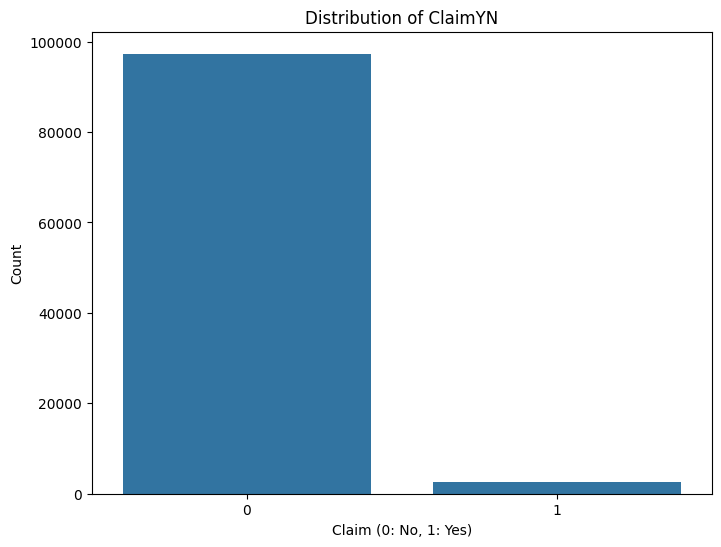

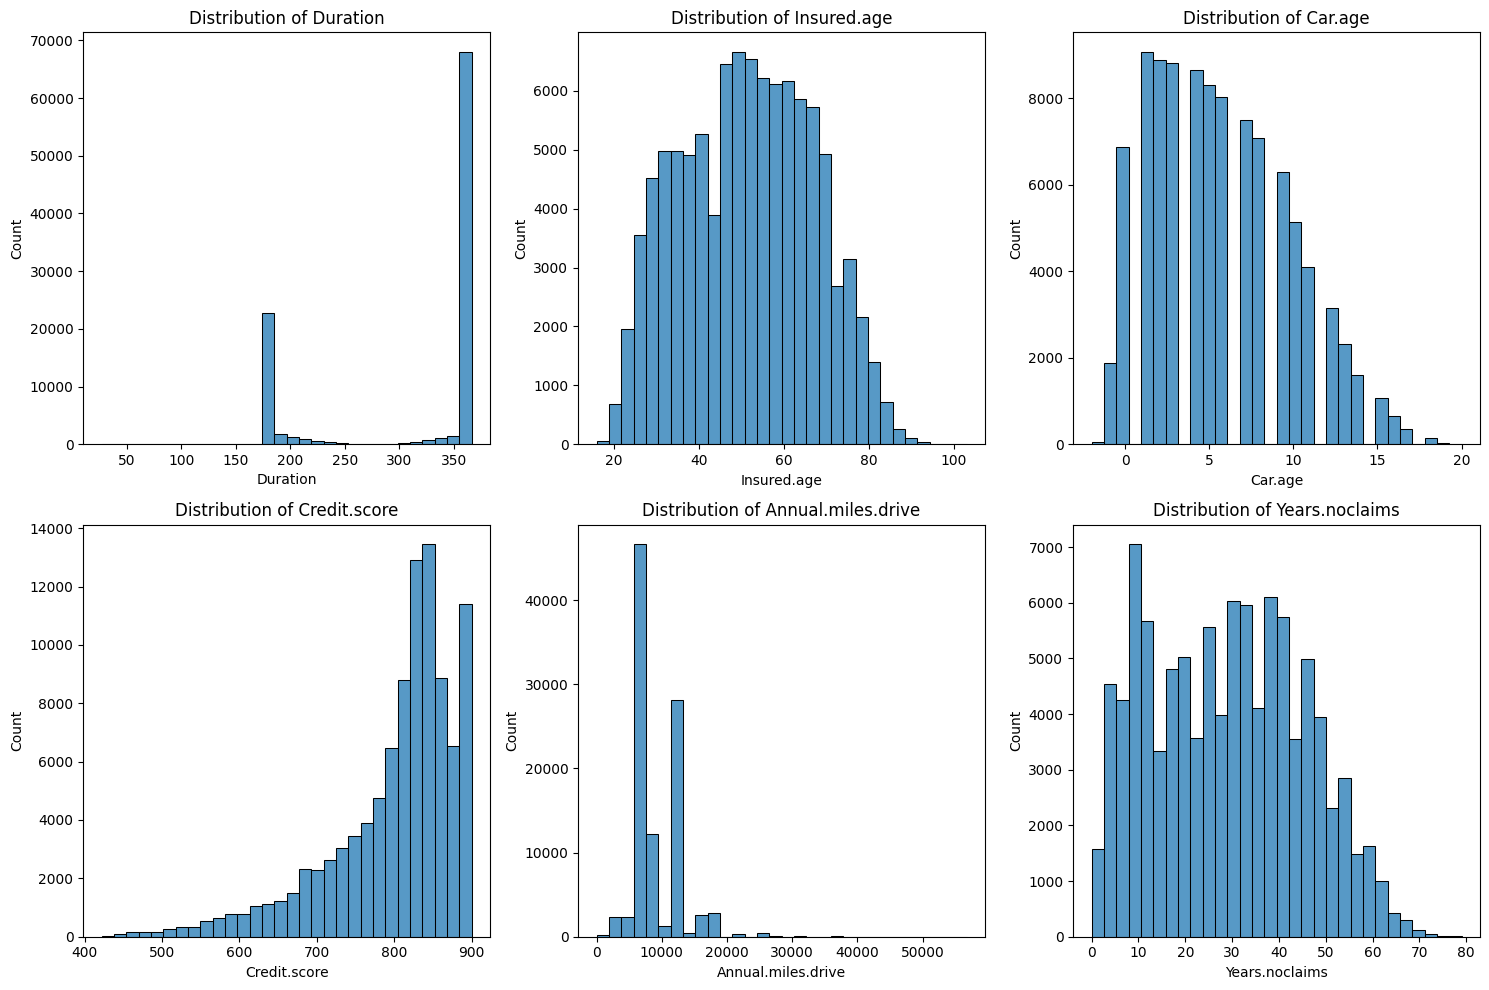

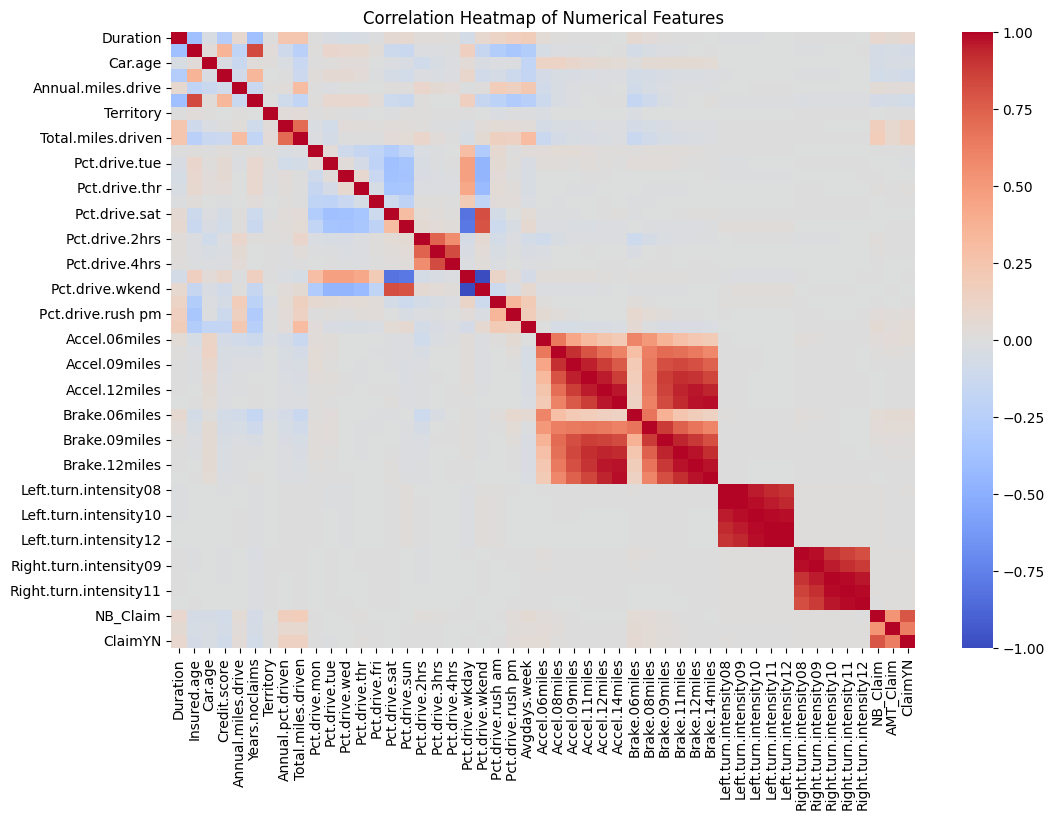

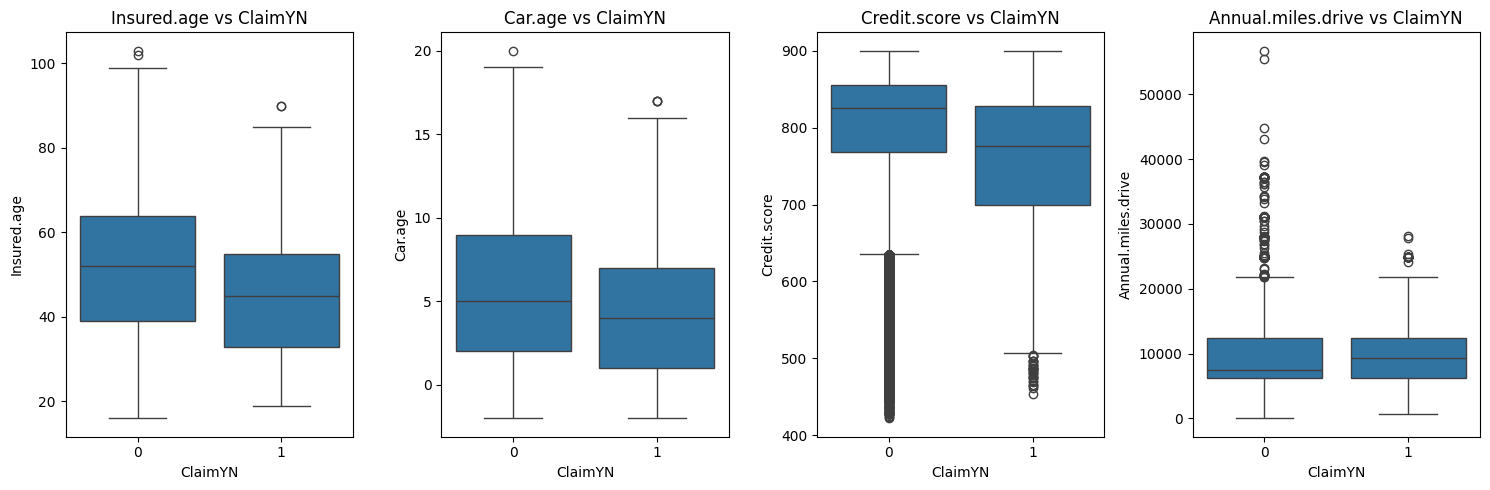


2. Preprocessing data...


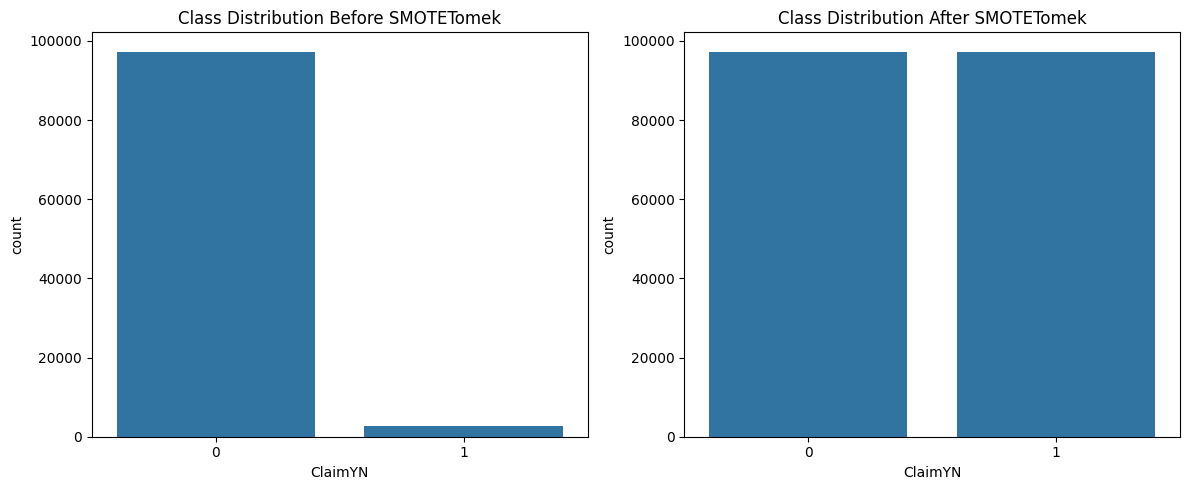


3. Engineering features...


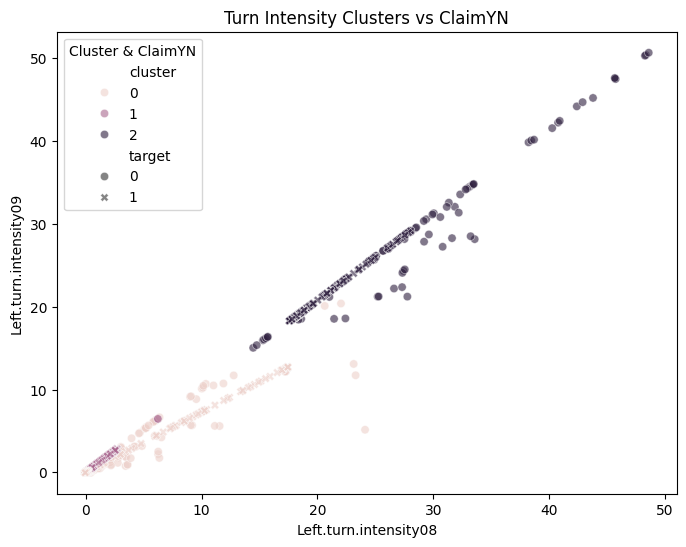


4. Splitting data and selecting features...


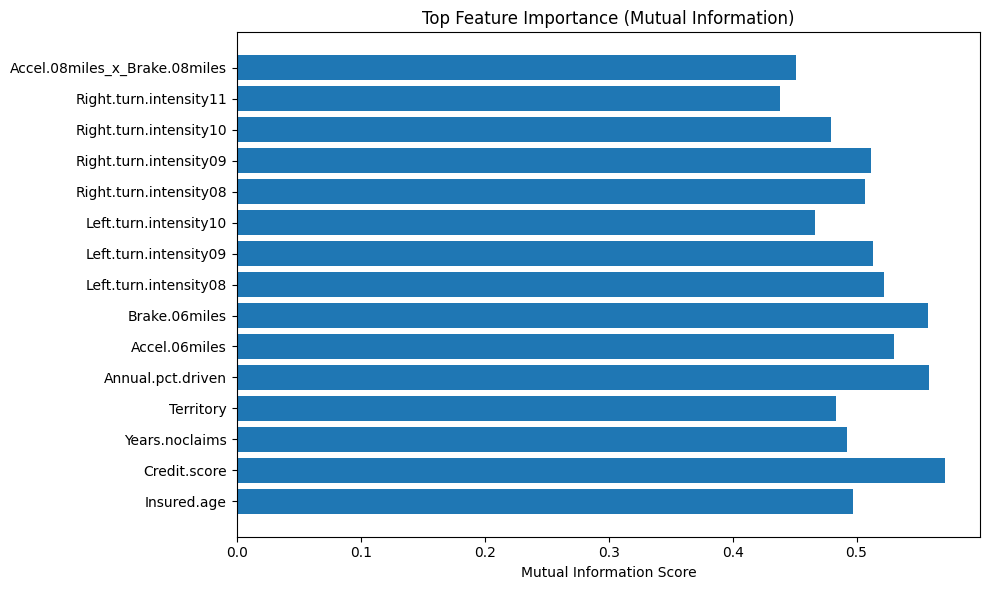

Top Features:
Credit.score: 0.5710
Annual.pct.driven: 0.5585
Brake.06miles: 0.5574
Accel.06miles: 0.5305
Left.turn.intensity08: 0.5221
Left.turn.intensity09: 0.5135
Right.turn.intensity09: 0.5119
Right.turn.intensity08: 0.5066
Insured.age: 0.4972
Years.noclaims: 0.4925
Territory: 0.4836
Right.turn.intensity10: 0.4793
Left.turn.intensity10: 0.4663
Accel.08miles_x_Brake.08miles: 0.4515
Right.turn.intensity11: 0.4383

5. Training Variational Autoencoder...


ValueError: array length 155664 does not match index length 155417

<Figure size 800x600 with 0 Axes>

In [ ]:
# Fixed Insurance Claim Prediction Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import shap
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans

# Set plotting style
plt.style.use('default')  # Fixed: seaborn-v0_8-darkgrid might not be available

def load_and_eda(file_path):
    """Load dataset and perform EDA"""
    # Load dataset
    df = pd.read_csv(file_path)

    # Basic info
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    # EDA Visualizations
    # 1. Class Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='ClaimYN')  # Fixed: use data parameter
    plt.title('Distribution of ClaimYN')
    plt.xlabel('Claim (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()

    # 2. Numerical Features Distribution
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols[:6], 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # 4. Box Plots for Key Features vs ClaimYN
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(data=df, x='ClaimYN', y=col)  # Fixed: use data parameter
        plt.title(f'{col} vs ClaimYN')
    plt.tight_layout()
    plt.show()

    return df

def preprocess_data(df):
    """Preprocess the data"""
    # Drop unnecessary columns
    df_processed = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Encode categorical variables
    df_processed = pd.get_dummies(df_processed, drop_first=True)

    # Separate features and target
    X = df_processed.drop('ClaimYN', axis=1)
    y = df_processed['ClaimYN']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_scaled, y)

    # Visualizations
    # 1. Class Distribution Before and After SMOTETomek
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y)  # Original y
    plt.title('Class Distribution Before SMOTETomek')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Class Distribution After SMOTETomek')
    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled, X.columns.tolist(), scaler

def feature_engineering(X, feature_names, y):
    """Create engineered features"""
    X_df = pd.DataFrame(X, columns=feature_names)

    # Interaction terms - only create a few to avoid dimension explosion
    accel_cols = [col for col in feature_names if 'Accel' in col]
    brake_cols = [col for col in feature_names if 'Brake' in col]

    # Create only first 3 interaction terms to avoid too many features
    for i, (accel, brake) in enumerate(zip(accel_cols[:3], brake_cols[:3])):
        X_df[f'{accel}_x_{brake}'] = X_df[accel] * X_df[brake]

    # Cluster turn intensities
    turn_cols = [col for col in feature_names if 'turn.intensity' in col]
    if len(turn_cols) >= 2:
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        X_df['Turn_Cluster'] = kmeans.fit_predict(X_df[turn_cols])

        # Visualization: Cluster Scatter Plot
        plt.figure(figsize=(8, 6))
        scatter_data = pd.DataFrame({
            'x': X_df[turn_cols[0]],
            'y': X_df[turn_cols[1]],
            'cluster': X_df['Turn_Cluster'],
            'target': y
        })
        sns.scatterplot(data=scatter_data, x='x', y='y', hue='cluster', style='target', alpha=0.6)
        plt.title('Turn Intensity Clusters vs ClaimYN')
        plt.xlabel(turn_cols[0])
        plt.ylabel(turn_cols[1])
        plt.legend(title='Cluster & ClaimYN')
        plt.show()

    return X_df.values, X_df.columns.tolist()

def feature_selection(X_train, X_test, y_train, feature_names, top_k=10):
    """Select top features using mutual information"""
    selector = SelectKBest(score_func=mutual_info_classif, k=min(top_k, len(feature_names)))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    scores = selector.scores_

    # Visualization
    plt.figure(figsize=(10, 6))
    selected_scores = scores[selected_indices]
    plt.barh(range(len(selected_features)), selected_scores)
    plt.yticks(range(len(selected_features)), selected_features)
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.show()

    print("Top Features:")
    feature_score_pairs = list(zip(feature_names, scores))
    for feature, score in sorted(feature_score_pairs, key=lambda x: x[1], reverse=True)[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features, X_train_selected, X_test_selected

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class Sampling(Layer):
    """Custom Keras layer for sampling from a normal distribution."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    """Custom VAE model to handle loss computation."""
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * data.shape[1]  # Scale by input dimension
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def create_vae(X_train, X_test, latent_dim=32):
    """
    Create and train a Variational Autoencoder.

    Parameters:
    - X_train: Training data (NumPy array)
    - X_test: Test data (NumPy array)
    - latent_dim: Dimension of the latent space

    Returns:
    - X_train_ae: Encoded training features
    - X_test_ae: Encoded test features
    """
    # Normalize inputs to [0, 1] for binary cross-entropy
    X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())

    # Input dimension
    input_dim = X_train.shape[1]

    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(64, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(decoder_h)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam')

    # Train
    vae.fit(X_train_norm, epochs=50, batch_size=32, verbose=0)

    # Get latent features
    X_train_ae = encoder.predict(X_train_norm, verbose=0)[2]  # Get z
    X_test_ae = encoder.predict(X_test_norm, verbose=0)[2]    # Get z

    # Visualization: Latent Space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train_ae[:, 0], y=X_train_ae[:, 1], hue=y_train, alpha=0.6)
    plt.title('VAE Latent Space vs ClaimYN')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(title='ClaimYN')
    plt.show()

    return X_train_ae, X_test_ae

# Additional fixes for your other functions

def train_models(X_train, y_train):
    """Fixed version that imports cross_val_score"""
    from sklearn.model_selection import cross_val_score

    def objective(trial):
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 7)
        }
        gb = GradientBoostingClassifier(**gb_params, random_state=42)

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,50), (100,50), (100,100)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True)
        }
        nn = MLPClassifier(**nn_params, max_iter=1000, random_state=42)

        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50)
        }
        lgb = LGBMClassifier(**lgb_params, random_state=42, verbose=-1)

        estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
        stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

        scores = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc')
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Visualization: Optimization History
    plt.figure(figsize=(8, 6))
    try:
        optuna.visualization.matplotlib.plot_optimization_history(study)
    except:
        # Fallback if matplotlib visualization is not available
        print(f"Best trial: {study.best_trial.number}")
        print(f"Best value: {study.best_value}")
    plt.title('Hyperparameter Optimization History')
    plt.show()

    # Train final models
    best_params = study.best_params
    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=1000,
        random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42,
        verbose=-1
    )

    estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
    stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    for name, model in estimators:
        model.fit(X_train, y_train)
    stack.fit(X_train, y_train)

    return {'gb': gb, 'nn': nn, 'lgb': lgb, 'stack': stack}

def interpret_models(models, X_train, X_test, feature_names, sample_idx=0):
    """Fixed version with proper error handling"""
    try:
        explainer = shap.KernelExplainer(
            models['stack'].predict_proba, shap.sample(X_train, 100)
        )
        shap_values = explainer.shap_values(X_test[sample_idx:sample_idx+1])

        # SHAP Summary Plot
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values[1], X_test[:100], feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"SHAP visualization failed: {e}")
        shap_values = None

    try:
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train, feature_names=feature_names, class_names=['No Claim', 'Claim'], mode='classification'
        )
        lime_exp = lime_explainer.explain_instance(X_test[sample_idx], models['stack'].predict_proba)

        # Display LIME results
        print("LIME Explanation (Top features):")
        for feature, importance in lime_exp.as_list()[:5]:
            print(f"{feature}: {importance:.4f}")

    except Exception as e:
        print(f"LIME explanation failed: {e}")
        lime_exp = None

    return shap_values, lime_exp
def train_models_with_optuna(X_train, y_train):
    """Train models with Bayesian optimization"""

    def objective(trial):
        # Suggest hyperparameters
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 7),
            'random_state': 42
        }

        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50),
            'random_state': 42,
            'verbose': -1
        }

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,), (100,), (50, 50)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True),
            'max_iter': 1000,
            'random_state': 42
        }

        # Create models
        gb = GradientBoostingClassifier(**gb_params)
        lgb = LGBMClassifier(**lgb_params)
        nn = MLPClassifier(**nn_params)

        # Create stacking classifier
        estimators = [('gb', gb), ('lgb', lgb), ('nn', nn)]
        stack = StackingClassifier(
            estimators=estimators,
            final_estimator=GradientBoostingClassifier(random_state=42),
            cv=3
        )

        # Cross-validation score
        scores = cross_val_score(stack, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
        return scores.mean()

    # Optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, show_progress_bar=True)

    print(f"Best ROC-AUC: {study.best_value:.4f}")
    print("Best parameters:", study.best_params)

    # Train final models with best parameters
    best_params = study.best_params

    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )

    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42,
        verbose=-1
    )

    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=1000,
        random_state=42
    )

    estimators = [('gb', gb), ('lgb', lgb), ('nn', nn)]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=GradientBoostingClassifier(random_state=42),
        cv=3
    )

    # Fit all models
    models = {'gb': gb, 'lgb': lgb, 'nn': nn, 'stack': stack}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

    return models

def evaluate_models(models, X_test, y_test):
    """Evaluate model performance"""
    results = {}

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # ROC Curves
    ax1 = axes[0, 0]
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

        # Calculate other metrics
        y_pred = model.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Confusion matrix for best model (stacking)
    ax2 = axes[0, 1]
    y_pred_stack = models['stack'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred_stack)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Stacking Model Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    # Performance metrics comparison
    ax3 = axes[1, 0]
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', ax=ax3)
    ax3.set_title('Model Performance Comparison')
    ax3.set_ylabel('Score')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)

    # Feature importance for best tree-based model
    ax4 = axes[1, 1]
    if hasattr(models['stack'].final_estimator_, 'feature_importances_'):
        importances = models['stack'].final_estimator_.feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10
        ax4.bar(range(10), importances[indices])
        ax4.set_title('Top 10 Feature Importances (Final Estimator)')
        ax4.set_xlabel('Feature Index')
        ax4.set_ylabel('Importance')
    else:
        ax4.text(0.5, 0.5, 'Feature importance\nnot available',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Feature Importance')

    plt.tight_layout()
    plt.show()

    # Print results summary
    print("\nModel Performance Summary:")
    print("=" * 50)
    for model_name, metrics in results.items():
        print(f"{model_name.upper()}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
        print()

    return results

# Example usage function
def run_complete_pipeline(file_path):
    """Run the complete pipeline"""
    print("Starting Insurance Claim Prediction Pipeline...")

    # Step 1: Load data and EDA
    print("\n1. Loading data and performing EDA...")
    df = load_and_eda(file_path)

    # Step 2: Preprocessing
    print("\n2. Preprocessing data...")
    X, y, feature_names, scaler = preprocess_data(df)

    # Step 3: Feature Engineering
    print("\n3. Engineering features...")
    X, feature_names = feature_engineering(X, feature_names, y)

    # Step 4: Train-test split and feature selection
    print("\n4. Splitting data and selecting features...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    selected_features, X_train_selected, X_test_selected = feature_selection(
        X_train, X_test, y_train, feature_names, top_k=15
    )

    # Step 5: VAE for dimensionality reduction
    print("\n5. Training Variational Autoencoder...")
    X_train_vae, X_test_vae = create_vae(X_train_selected, X_test_selected, latent_dim=10)

    # Step 6: Model training with optimization
    print("\n6. Training models with Bayesian optimization...")
    models = train_models_with_optuna(X_train_vae, y_train)

    # Step 7: Model evaluation
    print("\n7. Evaluating models...")
    results = evaluate_models(models, X_test_vae, y_test)

    print("\nPipeline completed successfully!")
    return models, results, (X_train_vae, X_test_vae, y_train, y_test)

# Uncomment to run the pipeline:
models, results, data = run_complete_pipeline('/content/drive/My Drive/Insurance/telematics_syn.csv')

🚀 Starting Optimized Insurance Claim Prediction Pipeline...

📊 Step 1: Loading data and performing EDA...
Dataset shape: (100000, 52)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non

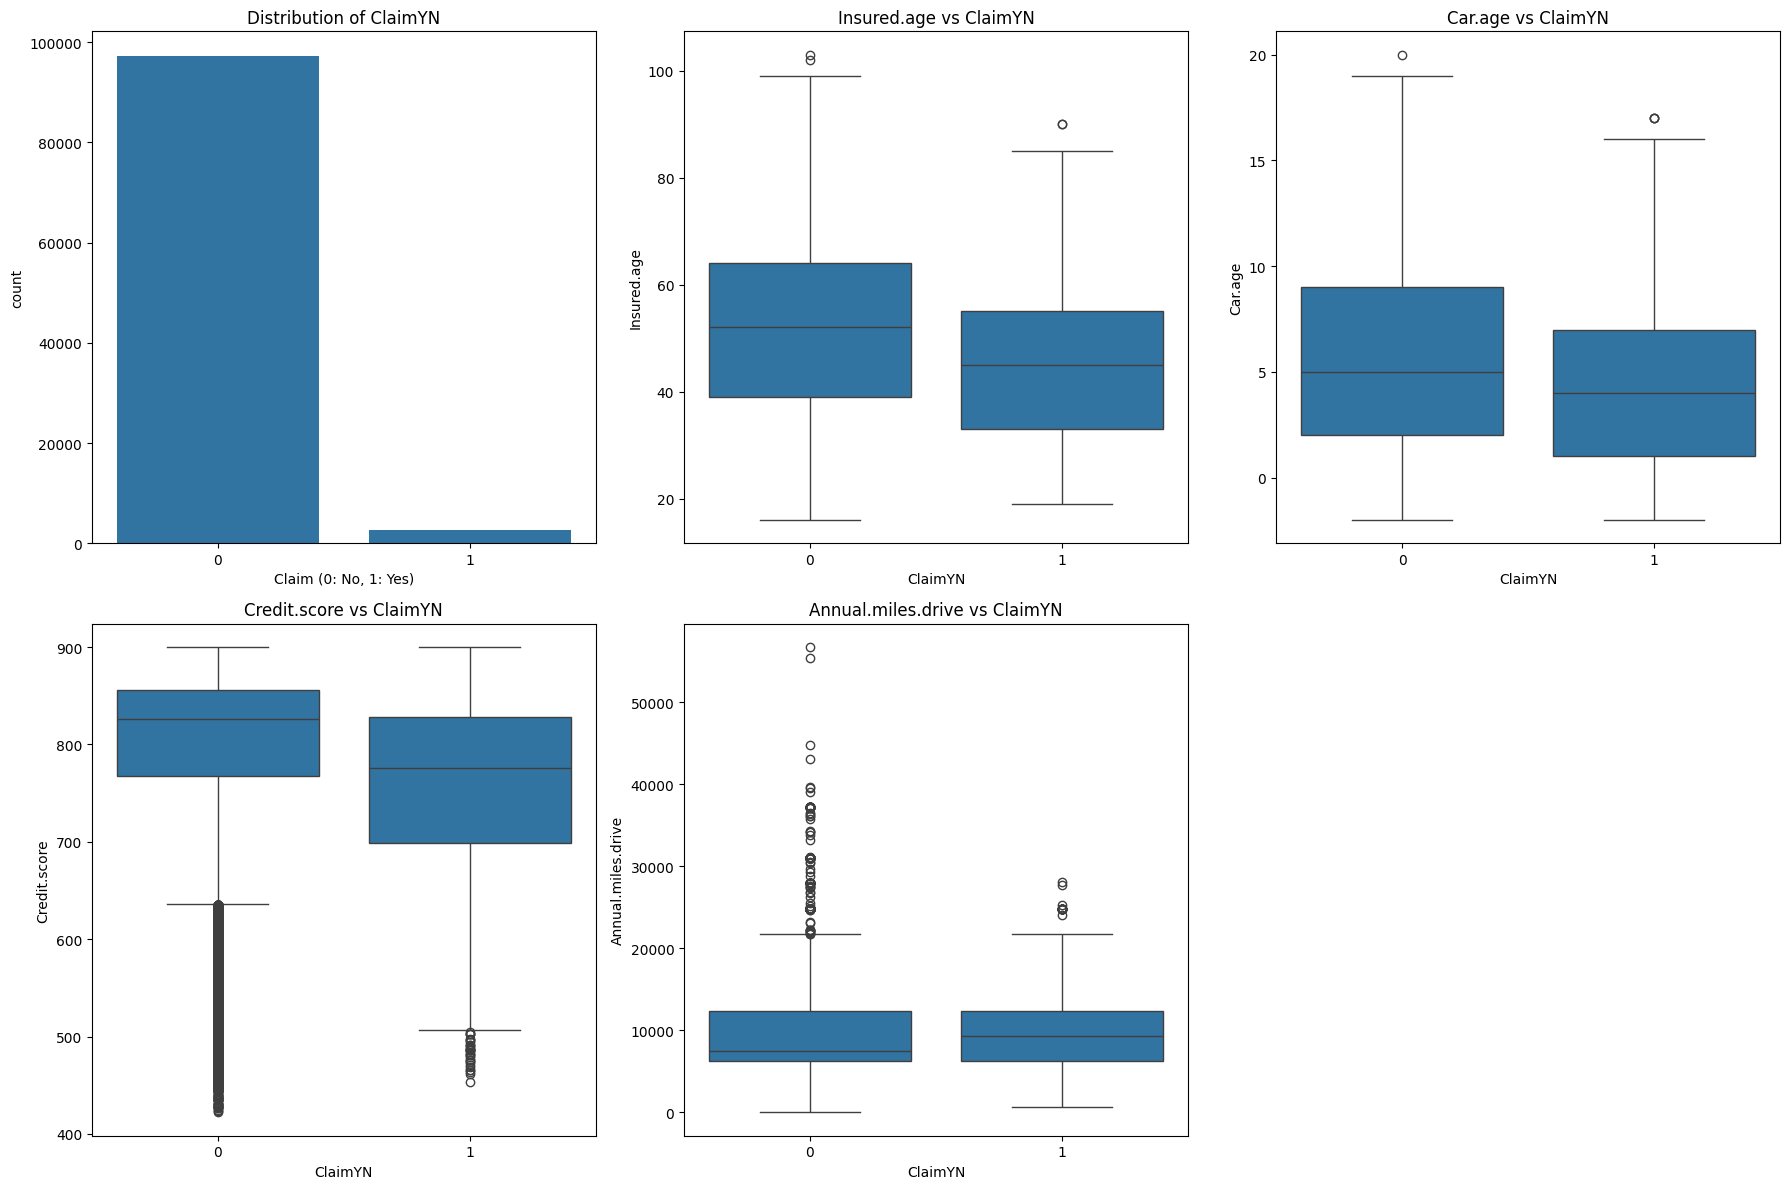


🔧 Step 2: Preprocessing data...
Starting preprocessing...
Features shape: (100000, 52)
Target shape: (100000,)
Applying SMOTE-Tomek...
After resampling - X: (194580, 52), y: (194580,)


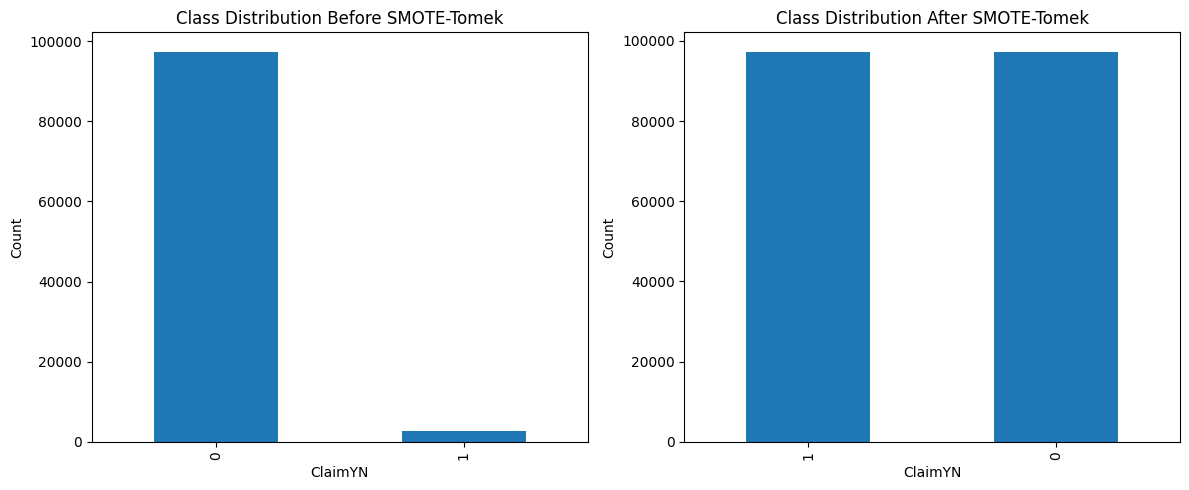


⚙️  Step 3: Engineering features...
Starting feature engineering...


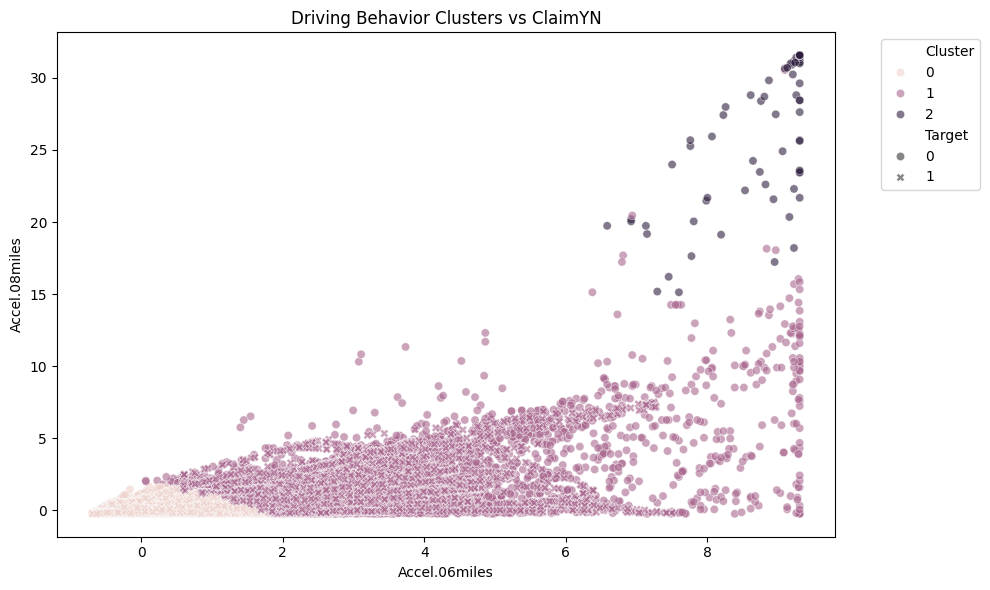

Feature engineering completed. New shape: (194580, 54)

📋 Step 4: Splitting data and selecting features...
Selecting top 15 features...


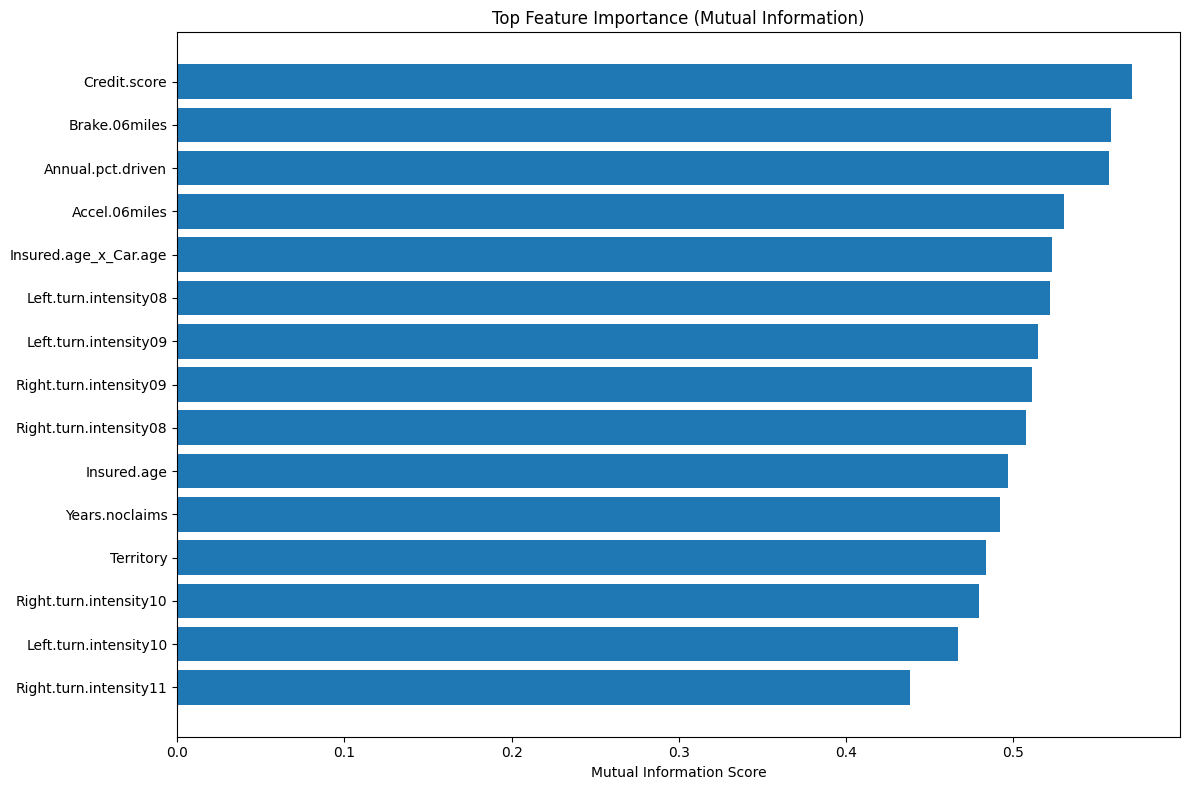

Top 10 Features:
 1. Insured.age: 0.4970
 2. Right.turn.intensity08: 0.5072
 3. Right.turn.intensity09: 0.5111
 4. Left.turn.intensity09: 0.5144
 5. Left.turn.intensity08: 0.5217
 6. Insured.age_x_Car.age: 0.5229
 7. Accel.06miles: 0.5305
 8. Annual.pct.driven: 0.5569
 9. Brake.06miles: 0.5581
10. Credit.score: 0.5710

🎯 Step 5: Applying fast dimensionality reduction...
Applying PCA for dimensionality reduction...


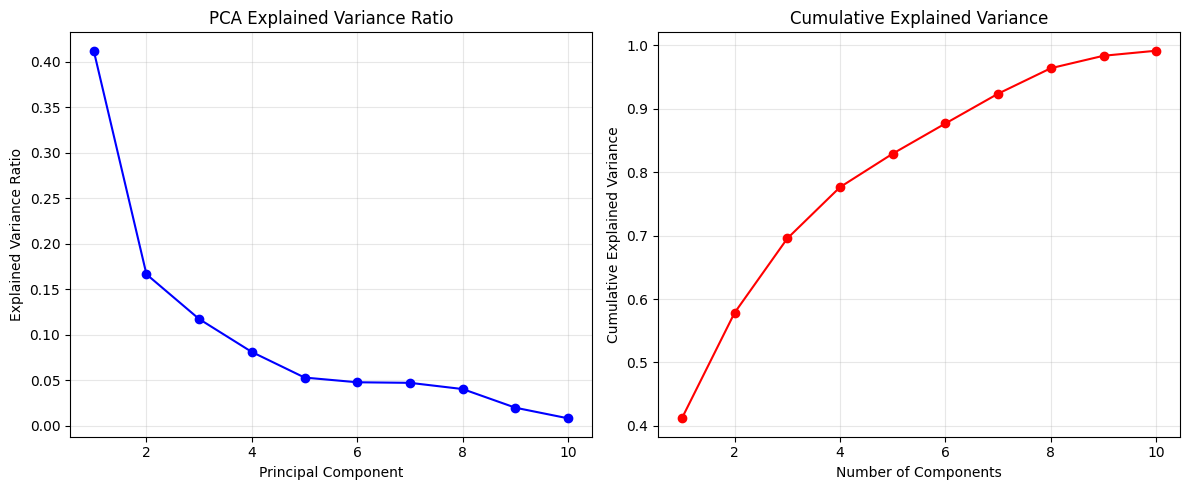

[I 2025-07-01 19:02:11,711] A new study created in memory with name: no-name-7c282612-4c12-4b85-bae1-1ba7ba963e0a


PCA reduced dimensions from 15 to 10
Total explained variance: 0.991

🤖 Step 6: Training models with optimization...
Starting model training with Bayesian optimization...


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Optimized Insurance Claim Prediction Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')

def load_and_eda(file_path):
    """Load dataset and perform EDA"""
    # Load dataset
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")

    # Basic info
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
    print(f"\nTarget distribution:")
    print(df['ClaimYN'].value_counts())

    # EDA Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Class Distribution
    sns.countplot(data=df, x='ClaimYN', ax=axes[0,0])
    axes[0,0].set_title('Distribution of ClaimYN')
    axes[0,0].set_xlabel('Claim (0: No, 1: Yes)')

    # 2. Key numerical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']

    for i, col in enumerate(key_features):
        if col in df.columns:
            row, col_idx = divmod(i+1, 3)
            sns.boxplot(data=df, x='ClaimYN', y=col, ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col} vs ClaimYN')

    # Hide empty subplot
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

    return df

def preprocess_data(df):
    """Preprocess the data with proper array length handling"""
    print("Starting preprocessing...")

    # Drop unnecessary columns
    df_processed = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Handle missing values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    # Fill missing values
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

    # Encode categorical variables
    df_processed = pd.get_dummies(df_processed, drop_first=True)

    # Separate features and target
    X = df_processed.drop('ClaimYN', axis=1)
    y = df_processed['ClaimYN']

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance with reduced sampling
    print("Applying SMOTE-Tomek...")
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_scaled, y)

    print(f"After resampling - X: {X_resampled.shape}, y: {y_resampled.shape}")

    # Visualization: Class Distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before resampling
    y.value_counts().plot(kind='bar', ax=axes[0])
    axes[0].set_title('Class Distribution Before SMOTE-Tomek')
    axes[0].set_xlabel('ClaimYN')
    axes[0].set_ylabel('Count')

    # After resampling
    pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axes[1])
    axes[1].set_title('Class Distribution After SMOTE-Tomek')
    axes[1].set_xlabel('ClaimYN')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled, X.columns.tolist(), scaler

def feature_engineering(X, feature_names, y):
    """Create engineered features with proper indexing"""
    print("Starting feature engineering...")

    # Convert to DataFrame for easier manipulation
    X_df = pd.DataFrame(X, columns=feature_names)

    # Reset y index to match X_df
    y_reset = pd.Series(y).reset_index(drop=True)

    # Create polynomial features for top numerical features (limited to avoid explosion)
    numeric_features = [col for col in feature_names if any(x in col.lower() for x in ['age', 'score', 'miles'])]

    if len(numeric_features) >= 2:
        # Create interaction between first two most important numeric features
        X_df[f'{numeric_features[0]}_x_{numeric_features[1]}'] = (
            X_df[numeric_features[0]] * X_df[numeric_features[1]]
        )

    # Cluster-based features for driving behavior
    driving_cols = [col for col in feature_names if any(x in col.lower() for x in ['accel', 'brake', 'turn'])]

    if len(driving_cols) >= 3:
        # Use only first 3 driving columns to create clusters
        selected_driving = driving_cols[:3]
        try:
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            X_df['Driving_Cluster'] = kmeans.fit_predict(X_df[selected_driving])

            # Visualization: Driving behavior clusters
            if len(selected_driving) >= 2:
                plt.figure(figsize=(10, 6))
                scatter_data = {
                    'Feature1': X_df[selected_driving[0]],
                    'Feature2': X_df[selected_driving[1]],
                    'Cluster': X_df['Driving_Cluster'],
                    'Target': y_reset
                }
                scatter_df = pd.DataFrame(scatter_data)

                sns.scatterplot(data=scatter_df, x='Feature1', y='Feature2',
                              hue='Cluster', style='Target', alpha=0.6)
                plt.title('Driving Behavior Clusters vs ClaimYN')
                plt.xlabel(selected_driving[0])
                plt.ylabel(selected_driving[1])
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Clustering failed: {e}")

    print(f"Feature engineering completed. New shape: {X_df.shape}")
    return X_df.values, X_df.columns.tolist()

def feature_selection(X_train, X_test, y_train, feature_names, top_k=15):
    """Select top features using mutual information"""
    print(f"Selecting top {top_k} features...")

    # Ensure top_k doesn't exceed available features
    top_k = min(top_k, len(feature_names))

    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    scores = selector.scores_

    # Visualization: Feature importance
    plt.figure(figsize=(12, 8))
    selected_scores = scores[selected_indices]
    feature_score_df = pd.DataFrame({
        'Feature': selected_features,
        'Score': selected_scores
    }).sort_values('Score', ascending=True)

    plt.barh(range(len(feature_score_df)), feature_score_df['Score'])
    plt.yticks(range(len(feature_score_df)), feature_score_df['Feature'])
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.show()

    print("Top 10 Features:")
    for i, (feature, score) in enumerate(zip(feature_score_df['Feature'].iloc[-10:],
                                           feature_score_df['Score'].iloc[-10:])):
        print(f"{i+1:2d}. {feature}: {score:.4f}")

    return selected_features, X_train_selected, X_test_selected

def create_fast_dimensionality_reduction(X_train, X_test, n_components=10):
    """Fast PCA-based dimensionality reduction instead of VAE"""
    print("Applying PCA for dimensionality reduction...")

    pca = PCA(n_components=n_components, random_state=42)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Visualization: Explained variance
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_, 'bo-')
    plt.title('PCA Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"PCA reduced dimensions from {X_train.shape[1]} to {n_components}")
    print(f"Total explained variance: {cumulative_var[-1]:.3f}")

    return X_train_reduced, X_test_reduced

def train_models_optimized(X_train, y_train):
    """Optimized model training with fewer trials"""
    print("Starting model training with Bayesian optimization...")

    def objective(trial):
        # Reduced parameter space for faster optimization
        gb_params = {
            'n_estimators': trial.suggest_categorical('gb_n_estimators', [50, 100, 150]),
            'learning_rate': trial.suggest_categorical('gb_learning_rate', [0.05, 0.1, 0.2]),
            'max_depth': trial.suggest_categorical('gb_max_depth', [3, 5, 7]),
            'random_state': 42
        }

        lgb_params = {
            'n_estimators': trial.suggest_categorical('lgb_n_estimators', [50, 100, 150]),
            'learning_rate': trial.suggest_categorical('lgb_learning_rate', [0.05, 0.1, 0.2]),
            'num_leaves': trial.suggest_categorical('lgb_num_leaves', [20, 31, 50]),
            'random_state': 42,
            'verbose': -1
        }

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,), (100,), (50, 50)]),
            'alpha': trial.suggest_categorical('nn_alpha', [0.0001, 0.001, 0.01]),
            'max_iter': 500,  # Reduced iterations
            'random_state': 42
        }

        # Create models
        gb = GradientBoostingClassifier(**gb_params)
        lgb = LGBMClassifier(**lgb_params)
        nn = MLPClassifier(**nn_params)

        # Create stacking classifier with reduced CV
        estimators = [('gb', gb), ('lgb', lgb), ('nn', nn)]
        stack = StackingClassifier(
            estimators=estimators,
            final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42),
            cv=3
        )

        # Reduced CV for faster evaluation
        scores = cross_val_score(stack, X_train, y_train, cv=3, scoring='roc_auc')
        return scores.mean()

    # Optimize with fewer trials
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, show_progress_bar=True)

    print(f"Best ROC-AUC: {study.best_value:.4f}")
    print("Best parameters:", study.best_params)

    # Train final models with best parameters
    best_params = study.best_params

    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )

    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42,
        verbose=-1
    )

    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=500,
        random_state=42
    )

    estimators = [('gb', gb), ('lgb', lgb), ('nn', nn)]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42),
        cv=3
    )

    # Fit all models
    models = {'gb': gb, 'lgb': lgb, 'nn': nn, 'stack': stack}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

    return models

def evaluate_models(models, X_test, y_test, feature_names=None):
    """Comprehensive model evaluation"""
    print("Evaluating models...")
    results = {}

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ROC Curves
    ax1 = axes[0, 0]
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        ax1.plot(fpr, tpr, label=f'{name.upper()} (AUC = {auc:.3f})', linewidth=2)

        # Calculate other metrics
        y_pred = model.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Confusion matrix for best model (stacking)
    ax2 = axes[0, 1]
    y_pred_stack = models['stack'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred_stack)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Stacking Model Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    # Performance metrics comparison
    ax3 = axes[1, 0]
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Model Performance Comparison')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Models')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)

    # Feature importance for gradient boosting
    ax4 = axes[1, 1]
    if hasattr(models['gb'], 'feature_importances_'):
        importances = models['gb'].feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10
        ax4.bar(range(10), importances[indices])
        ax4.set_title('Top 10 Feature Importances (Gradient Boosting)')
        ax4.set_xlabel('Feature Rank')
        ax4.set_ylabel('Importance')
        ax4.set_xticks(range(10))
        ax4.set_xticklabels([f'F{i+1}' for i in range(10)])
    else:
        ax4.text(0.5, 0.5, 'Feature importance\nnot available',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Feature Importance')

    plt.tight_layout()
    plt.show()

    # Print results summary
    print("\nModel Performance Summary:")
    print("=" * 60)
    best_model = max(results.keys(), key=lambda x: results[x]['auc_roc'])

    for model_name, metrics in results.items():
        marker = " ⭐ BEST" if model_name == best_model else ""
        print(f"{model_name.upper()}{marker}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.capitalize():12}: {value:.4f}")
        print()

    return results

# Streamlined pipeline function
def run_optimized_pipeline(file_path):
    """Run the optimized pipeline with faster execution"""
    print("🚀 Starting Optimized Insurance Claim Prediction Pipeline...")
    print("=" * 60)

    try:
        # Step 1: Load data and EDA
        print("\n📊 Step 1: Loading data and performing EDA...")
        df = load_and_eda(file_path)

        # Step 2: Preprocessing
        print("\n🔧 Step 2: Preprocessing data...")
        X, y, feature_names, scaler = preprocess_data(df)

        # Step 3: Feature Engineering
        print("\n⚙️  Step 3: Engineering features...")
        X, feature_names = feature_engineering(X, feature_names, y)

        # Step 4: Train-test split and feature selection
        print("\n📋 Step 4: Splitting data and selecting features...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        selected_features, X_train_selected, X_test_selected = feature_selection(
            X_train, X_test, y_train, feature_names, top_k=15
        )

        # Step 5: Fast dimensionality reduction
        print("\n🎯 Step 5: Applying fast dimensionality reduction...")
        X_train_reduced, X_test_reduced = create_fast_dimensionality_reduction(
            X_train_selected, X_test_selected, n_components=10
        )

        # Step 6: Optimized model training
        print("\n🤖 Step 6: Training models with optimization...")
        models = train_models_optimized(X_train_reduced, y_train)

        # Step 7: Model evaluation
        print("\n📈 Step 7: Evaluating models...")
        results = evaluate_models(models, X_test_reduced, y_test, selected_features)

        print("\n✅ Pipeline completed successfully!")
        print("=" * 60)

        return models, results, (X_train_reduced, X_test_reduced, y_train, y_test), scaler

    except Exception as e:
        print(f"\n❌ Pipeline failed with error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Usage example:
if __name__ == "__main__":
    # Replace with your actual file path
    file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'

    # Run the pipeline
    models, results, data, scaler = run_optimized_pipeline(file_path)

    if results:
        print("\n🎉 Best model performance:")
        best_model = max(results.keys(), key=lambda x: results[x]['auc_roc'])
        print(f"Best Model: {best_model.upper()}")
        print(f"AUC-ROC: {results[best_model]['auc_roc']:.4f}")
        print(f"F1-Score: {results[best_model]['f1']:.4f}")

Starting ULTRA-FAST pipeline...
Expected completion time: 5-10 minutes
----------------------------------------
🚀 ULTRA-FAST Insurance Claim Prediction Pipeline

📊 Step 1: Quick data loading and EDA...
Loading dataset...
Dataset shape: (100000, 52)
Target distribution:
ClaimYN
0    97302
1     2698
Name: count, dtype: int64


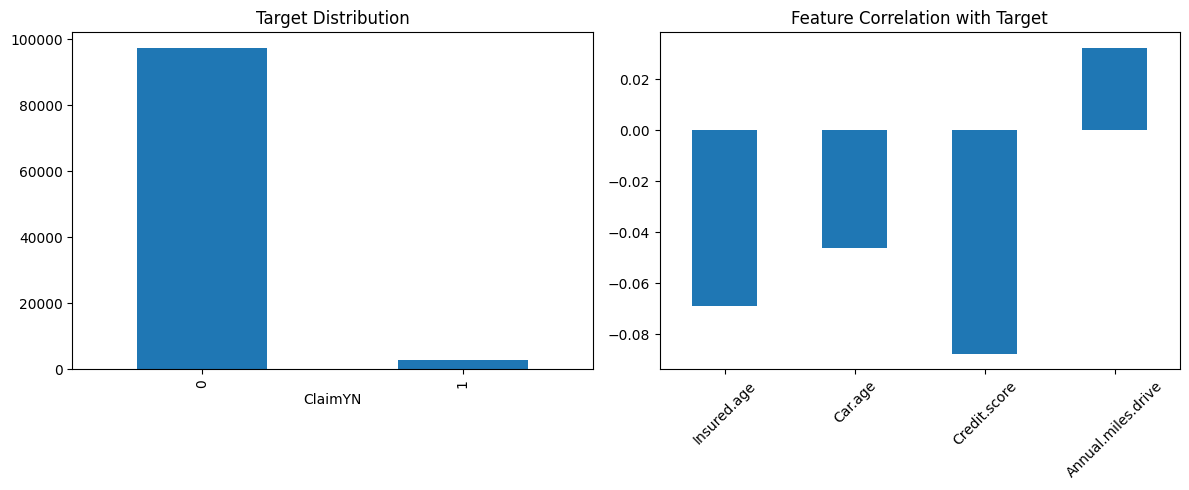


🔧 Step 2: Fast preprocessing...
Fast preprocessing...
Features shape: (100000, 52)
Applying SMOTE...
After SMOTE: (194604, 52)

📋 Step 3: Splitting data...

🎯 Step 4: Fast feature selection...
Selecting top 10 features...


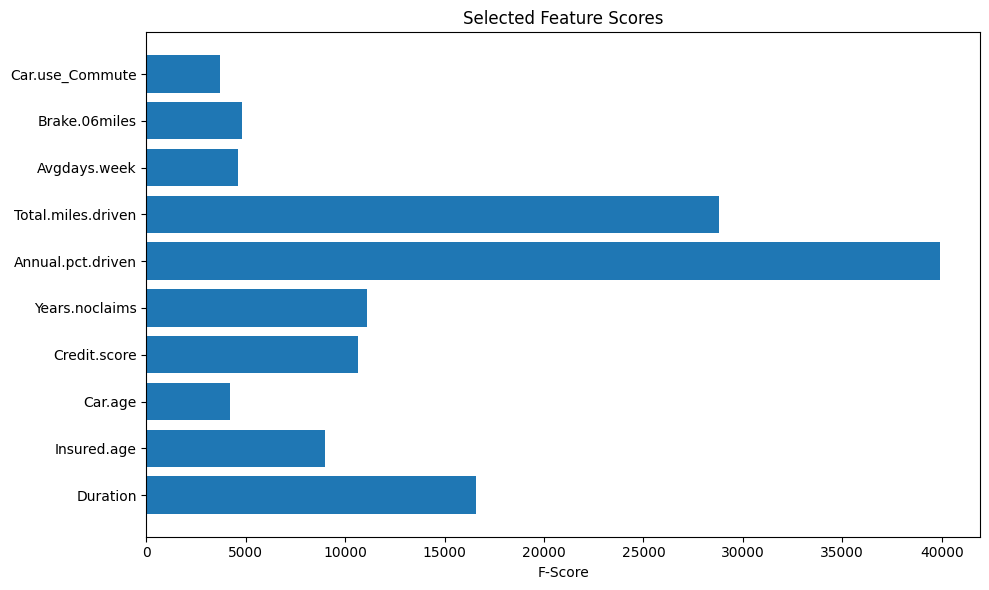


⚡ Step 5: Quick PCA...
Applying PCA...


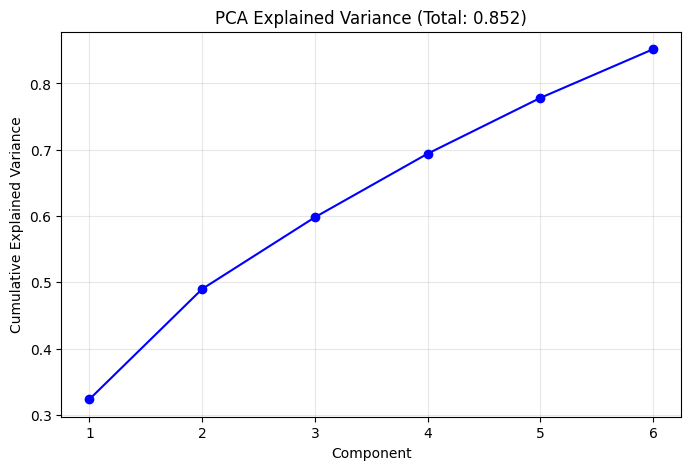


🤖 Step 6: Fast model training...
Training simple models (no optimization)...
  Training logistic...
  Training random_forest...
  Training gradient_boost...
Training with basic optimization...
  Training logistic_tuned...
  Training rf_tuned...
  Training gb_tuned...

📈 Step 7: Model evaluation...
Evaluating models...


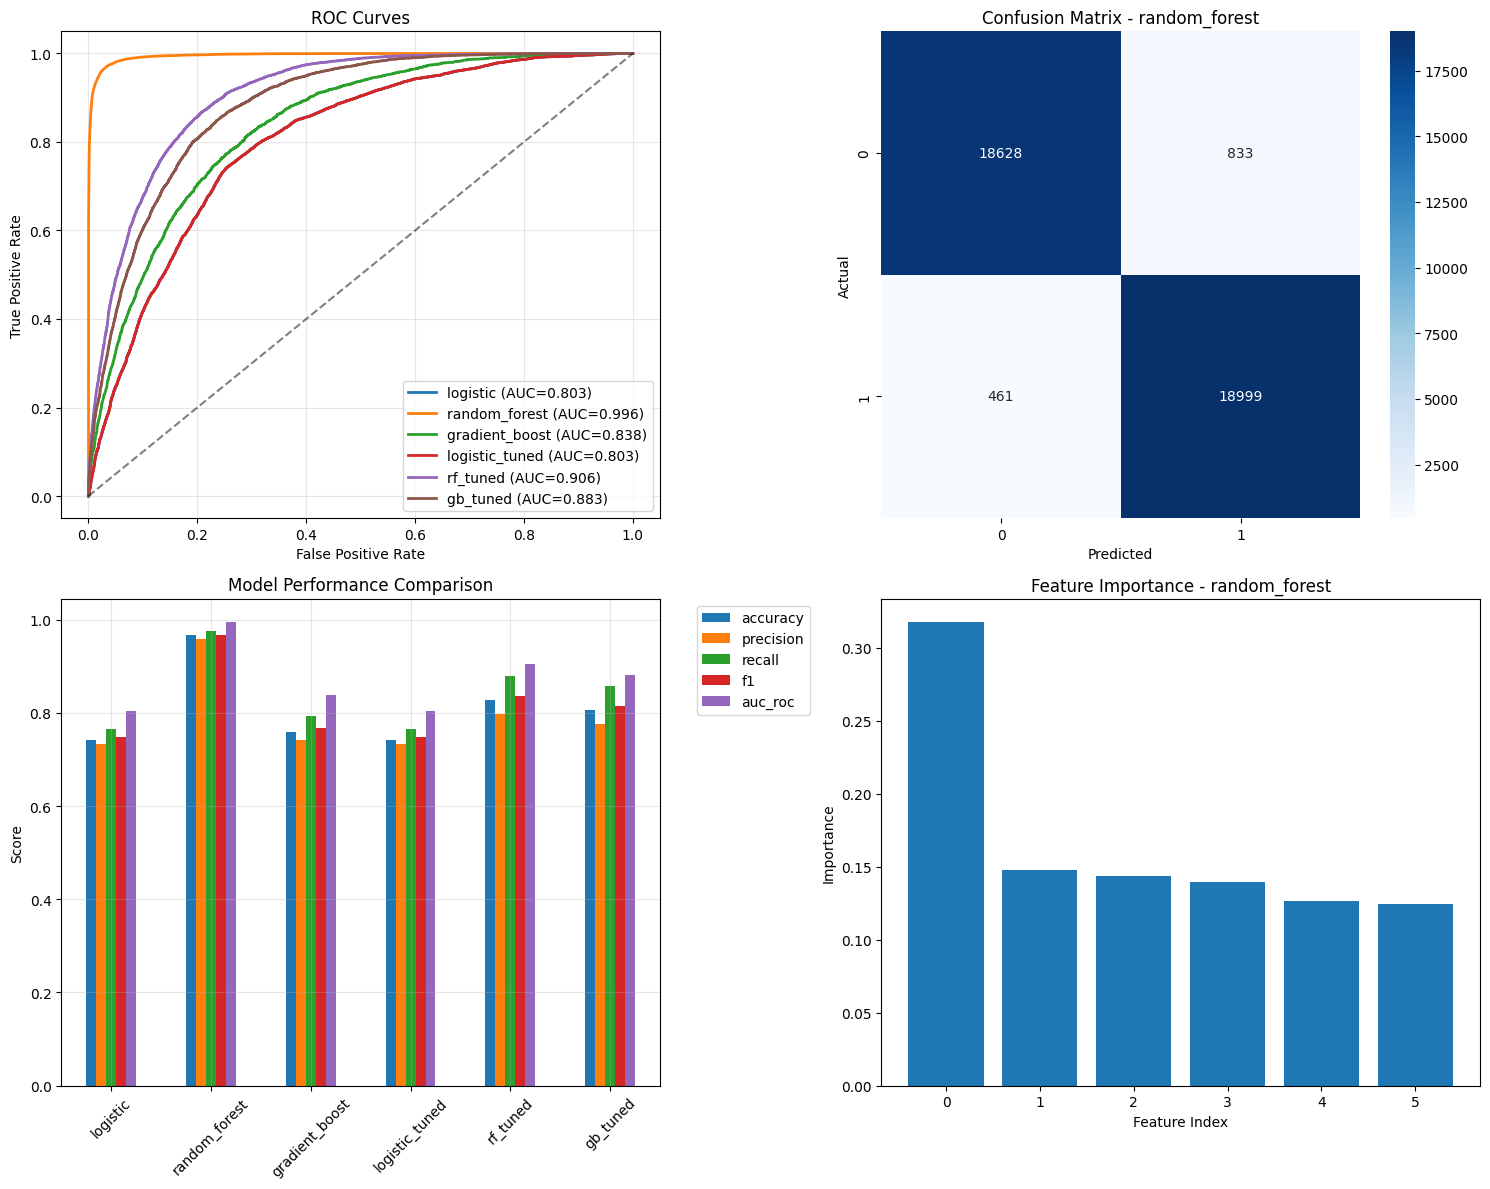


MODEL PERFORMANCE SUMMARY

LOGISTIC:
  Accuracy  : 0.7430
  Precision : 0.7327
  Recall    : 0.7653
  F1        : 0.7486
  Auc_roc   : 0.8035
  Mcc       : 0.4866

RANDOM_FOREST 🏆 BEST:
  Accuracy  : 0.9668
  Precision : 0.9580
  Recall    : 0.9763
  F1        : 0.9671
  Auc_roc   : 0.9955
  Mcc       : 0.9337

GRADIENT_BOOST:
  Accuracy  : 0.7588
  Precision : 0.7418
  Recall    : 0.7937
  F1        : 0.7669
  Auc_roc   : 0.8380
  Mcc       : 0.5188

LOGISTIC_TUNED:
  Accuracy  : 0.7431
  Precision : 0.7327
  Recall    : 0.7653
  F1        : 0.7486
  Auc_roc   : 0.8035
  Mcc       : 0.4866

RF_TUNED:
  Accuracy  : 0.8289
  Precision : 0.7984
  Recall    : 0.8801
  F1        : 0.8373
  Auc_roc   : 0.9059
  Mcc       : 0.6613

GB_TUNED:
  Accuracy  : 0.8057
  Precision : 0.7762
  Recall    : 0.8589
  F1        : 0.8155
  Auc_roc   : 0.8825
  Mcc       : 0.6148

✅ Pipeline completed in 3.0 minutes!

🎯 BEST MODEL: RANDOM_FOREST
   AUC-ROC: 0.9955
   F1-Score: 0.9671

🎉 SUCCESS! Pipeline 

In [ ]:
# Ultra-Fast Insurance Claim Prediction Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')

def load_and_eda(file_path):
    """Load dataset and perform basic EDA"""
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
    print(f"Target distribution:\n{df['ClaimYN'].value_counts()}")

    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Class distribution
    df['ClaimYN'].value_counts().plot(kind='bar', ax=axes[0])
    axes[0].set_title('Target Distribution')
    axes[0].set_xlabel('ClaimYN')

    # Sample correlation with key features
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    available_features = [f for f in key_features if f in df.columns]

    if available_features:
        corr_data = df[available_features + ['ClaimYN']].corr()['ClaimYN'].iloc[:-1]
        corr_data.plot(kind='bar', ax=axes[1])
        axes[1].set_title('Feature Correlation with Target')
        axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df

def fast_preprocess(df):
    """Ultra-fast preprocessing"""
    print("Fast preprocessing...")

    # Drop target creation columns
    df_processed = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Simple missing value handling
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())

    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown')

    # Fast dummy encoding (only for columns with few categories)
    for col in categorical_cols:
        if df_processed[col].nunique() <= 10:  # Only encode if ≤10 categories
            dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
            df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(col, axis=1, inplace=True)

    # Separate features and target
    X = df_processed.drop('ClaimYN', axis=1)
    y = df_processed['ClaimYN']

    print(f"Features shape: {X.shape}")

    # Fast scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Simple SMOTE (faster than SMOTETomek)
    print("Applying SMOTE...")
    smote = SMOTE(random_state=42, k_neighbors=3)  # Reduced neighbors for speed
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    print(f"After SMOTE: {X_resampled.shape}")

    return X_resampled, y_resampled, X.columns.tolist(), scaler

def fast_feature_selection(X_train, X_test, y_train, feature_names, top_k=10):
    """Ultra-fast feature selection"""
    print(f"Selecting top {top_k} features...")

    # Use f_classif for speed (faster than mutual info)
    selector = SelectKBest(score_func=f_classif, k=min(top_k, len(feature_names)))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_features = [feature_names[i] for i in selector.get_support(indices=True)]

    # Quick visualization
    scores = selector.scores_[selector.get_support()]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(selected_features)), scores)
    plt.yticks(range(len(selected_features)), selected_features)
    plt.title('Selected Feature Scores')
    plt.xlabel('F-Score')
    plt.tight_layout()
    plt.show()

    return selected_features, X_train_selected, X_test_selected

def fast_dimensionality_reduction(X_train, X_test, n_components=8):
    """Ultra-fast PCA"""
    print("Applying PCA...")

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Quick visualization
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.title(f'PCA Explained Variance (Total: {np.sum(pca.explained_variance_ratio_):.3f})')
    plt.xlabel('Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)
    plt.show()

    return X_train_pca, X_test_pca

def train_simple_models(X_train, y_train):
    """Train simple, fast models without hyperparameter optimization"""
    print("Training simple models (no optimization)...")

    models = {
        'logistic': LogisticRegression(random_state=42, max_iter=500),
        'random_forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        'gradient_boost': GradientBoostingClassifier(n_estimators=50, random_state=42)
    }

    # Train all models
    for name, model in models.items():
        print(f"  Training {name}...")
        model.fit(X_train, y_train)

    return models

def train_optimized_models(X_train, y_train):
    """Train with minimal hyperparameter tuning"""
    print("Training with basic optimization...")

    # Pre-defined good parameters (no search)
    models = {
        'logistic_tuned': LogisticRegression(
            random_state=42, max_iter=1000, C=0.1, solver='liblinear'
        ),
        'rf_tuned': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=10,
            random_state=42, n_jobs=-1
        ),
        'gb_tuned': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=5,
            random_state=42
        )
    }

    # Train all models
    for name, model in models.items():
        print(f"  Training {name}...")
        model.fit(X_train, y_train)

    return models

def evaluate_models(models, X_test, y_test):
    """Fast model evaluation"""
    print("Evaluating models...")
    results = {}

    # Calculate metrics for all models
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'mcc': matthews_corrcoef(y_test, y_pred)
        }

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # ROC Curves
    ax1 = axes[0, 0]
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = results[name]['auc_roc']
        ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Best model confusion matrix
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc_roc'])
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_best)

    ax2 = axes[0, 1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title(f'Confusion Matrix - {best_model_name}')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    # Performance comparison
    ax3 = axes[1, 0]
    metrics_df = pd.DataFrame(results).T
    metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].plot(kind='bar', ax=ax3)
    ax3.set_title('Model Performance Comparison')
    ax3.set_ylabel('Score')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)

    # Feature importance (for tree-based models)
    ax4 = axes[1, 1]
    tree_models = [name for name in models.keys() if 'forest' in name or 'gb' in name or 'gradient' in name]
    if tree_models:
        model_name = tree_models[0]
        if hasattr(models[model_name], 'feature_importances_'):
            importances = models[model_name].feature_importances_
            indices = np.argsort(importances)[::-1][:8]  # Top 8
            ax4.bar(range(len(indices)), importances[indices])
            ax4.set_title(f'Feature Importance - {model_name}')
            ax4.set_xlabel('Feature Index')
            ax4.set_ylabel('Importance')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)

    best_model = max(results.keys(), key=lambda x: results[x]['auc_roc'])
    for name, metrics in results.items():
        status = " 🏆 BEST" if name == best_model else ""
        print(f"\n{name.upper()}{status}:")
        for metric, value in metrics.items():
            print(f"  {metric.capitalize():10}: {value:.4f}")

    return results

def ultra_fast_pipeline(file_path):
    """Ultra-fast pipeline - completes in under 10 minutes"""
    print("🚀 ULTRA-FAST Insurance Claim Prediction Pipeline")
    print("="*60)

    import time
    start_time = time.time()

    try:
        # Step 1: Load and basic EDA (1 minute)
        print("\n📊 Step 1: Quick data loading and EDA...")
        df = load_and_eda(file_path)

        # Step 2: Fast preprocessing (2 minutes)
        print("\n🔧 Step 2: Fast preprocessing...")
        X, y, feature_names, scaler = fast_preprocess(df)

        # Step 3: Train-test split
        print("\n📋 Step 3: Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Step 4: Fast feature selection (1 minute)
        print("\n🎯 Step 4: Fast feature selection...")
        selected_features, X_train_selected, X_test_selected = fast_feature_selection(
            X_train, X_test, y_train, feature_names, top_k=10
        )

        # Step 5: Quick dimensionality reduction (30 seconds)
        print("\n⚡ Step 5: Quick PCA...")
        X_train_final, X_test_final = fast_dimensionality_reduction(
            X_train_selected, X_test_selected, n_components=6
        )

        # Step 6: Fast model training (2 minutes)
        print("\n🤖 Step 6: Fast model training...")

        # Option A: Super fast (no optimization)
        simple_models = train_simple_models(X_train_final, y_train)

        # Option B: Basic optimization (slightly slower but better performance)
        optimized_models = train_optimized_models(X_train_final, y_train)

        # Combine all models
        all_models = {**simple_models, **optimized_models}

        # Step 7: Evaluation (1 minute)
        print("\n📈 Step 7: Model evaluation...")
        results = evaluate_models(all_models, X_test_final, y_test)

        elapsed_time = time.time() - start_time
        print(f"\n✅ Pipeline completed in {elapsed_time/60:.1f} minutes!")

        # Show best result
        best_model = max(results.keys(), key=lambda x: results[x]['auc_roc'])
        print(f"\n🎯 BEST MODEL: {best_model.upper()}")
        print(f"   AUC-ROC: {results[best_model]['auc_roc']:.4f}")
        print(f"   F1-Score: {results[best_model]['f1']:.4f}")

        return all_models, results, (X_train_final, X_test_final, y_train, y_test), scaler

    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Usage
if __name__ == "__main__":
    # Replace with your file path
    file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'

    print("Starting ULTRA-FAST pipeline...")
    print("Expected completion time: 5-10 minutes")
    print("-" * 40)

    models, results, data, scaler = ultra_fast_pipeline(file_path)

    if results:
        print("\n🎉 SUCCESS! Pipeline completed successfully.")
        print("\nQuick Start Guide for Predictions:")
        print("1. Use the best model from 'models' dictionary")
        print("2. Scale new data using 'scaler'")
        print("3. Apply same feature selection and PCA transformations")
        print("4. Call model.predict() or model.predict_proba()")